**Master Thesis Fabian Asal; Final Notebook**

- Title: Leveraging Label Descriptions to Improve Multi-Label Text Classification for Short Noisy Medical Text
- Date: 22.01.2020
- Copyright LEAM: Guoyin Wang, Chunyuan Li, Wenlin Wang, Yizhe Zhang, Dinghan Shen, Xinyuan Zhang, Ricardo Henao, Lawrence Carin
- Link to LEAM: https://github.com/guoyinwang/LEAM


# Setup

## Packages 

- Loading necesarry Python packages
- LEAM is implemented in Python 2.7 and tensorFlow 1.7, which need to be installed in case one wants to run LEAM in the notebook
- We did the pre-processing and all the other steps locally in Python 3.7, exportet the files for LEAM in pickle format and run LEAM with Google Colab on a GPU


In [1381]:
# loading necessary libraries 
# python version 2.7 and tensorflow 1.7 is needed to run LEAM
import os, sys, pickle, re, string, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import table 
import csv
import pdb
import operator
import argparse

from collections import Counter
import PIL
from PIL import Image
import nltk
import textract
from wordcloud import WordCloud

from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score, f1_score, hamming_loss, accuracy_score

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.losses import binary_crossentropy
from keras.optimizers import Adam
from keras.layers import Dense, LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MultiLabelBinarizer

import tensorflow as tf
#from tensorflow.contrib import layers
import fasttext
import chars2vec

import scipy.io as sio
from math import floor
from random import shuffle
import warnings
from IPython.core.display import display, HTML

In [869]:
# set options
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.2f}%'.format
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

In [870]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

## Data
- the used dataset can not be made publicly available, since it contains personal medical information and has a copyright by the AOK Nordost 
- the notebook also contains the data extraction process (described in Chapter 3.4.1)

In [871]:
path= '/Users/fabian/Desktop/IBM_Thesis/03_Python/labelEmbedding/LEAM/data/'
raw_dec06= ('%s/aok/raw_dec06.csv' % path)
label_descriptions= ('%s/aok/label_descriptions_standardized.csv' % path)

In [872]:
df_raw_dec06= pd.read_csv(raw_dec06, 
                       sep = ';', encoding = 'utf-8', 
                       names=['gpos','text']
                      )

print("Dataset shape:",df_raw_dec06.shape)
df_raw_dec06.head()

Dataset shape: (15500, 2)


,gpos,text
0,"032298,032299,",LOIStUnY KOMPRESSOOSS IRUMDI HOHPRESSIOOSS IRÜMPH 11 AOZEHER SUSZIEHEN
1,"032233,032308,032387,032201,",Leistung Medikamentengabe KompressionsverbÃ¤nde Anlegen Konprenionseerbande abnehmen RR- Kontrolle
2,"032322,",LEISTUNG 83712 Nerkandswecsc 374
3,"032325,032233,",L1 : i.m . Injektionen LO : Medikamente verabreichen/Ã¼berwachen
4,"032234,",CO Angentropfnf-Salbe


## Extraction

- functions to extract and process text layers and labels from production process:
        1. a) crop text field from TIFF to feed TIFF into OCR software
        or:1 b) extract text field from PDF with regEX 
        2. extract text field from PDF  
        3. extract lables from TXT file
        4. join text and labels on fileID

In [1176]:
#  1. a) crop text field from TIFF to feed TIFF into OCR software

def crop_tiff(path_tiff, tifd_folder, out_folder):
    """Loop through tiff foldern, crop text field and return cropped TIFFs"""

    
    for folder in os.listdir(path_tiff):
        worked=0;exception=0;
        
        for fname in folder:
            if fname.endswith(".tif"): 
                sourceFile=os.path.join(tif_folder, fname)

                try:
                    im = Image.open(sourceFile)
                    page= im.seek(1)
                    cropped = im.crop( (60, 1330, 1110 , 1590 ) )

                    file_name = 'cropped_' + str(fname)
                    full_path = os.path.join(out_folder, file_name)

                    with open(full_path,"wb") as out_f:
                        output.write(out_f)
                        worked+=1

                except:
                    exception+=1

        print("worked:",worked," exception:",exception)

In [1177]:
# 1 b) extract text field from PDF with regEX and defined text markers

beginning_text_field = 'Angaben des Pflegedienstes'
end_text_field: "Die Pflege wird durchgeführt von einem zugelassenen Pflegedienst"

def my_parser1(string, m1, m2):
    start= string.find(m1) + len(m1)
    end= string.find(m2)
    core= string[start:end]
    tokens= core.split()
    clean= ' '.join(tokens)
    return clean

def regEX_text(path):
    file_name= []; full_text= []; core_text= []

    for fname in os.listdir(path):
        if fname.endswith(".pdf"): 
            sourceFile=os.path.join(dir_path, fname)
            file_name.append(sourceFile)

            text= textract.process(sourceFile); text= text.decode("utf-8"); full_text.append(text)

            core= my_parser1(string=kern2,m1= beginning_text_field, m2= end_text_field)

            if len(kern3) <500:
                core.append(kern3)
            else:
                core.append(error)
            df_out = pd.DataFrame({'file_name': file_name,'length': length,'complete_text':full_text,'core': core})
            
            return df_out

In [1178]:
# 2. extract text field from PDF 

def extract_text(path_pdf):
    """Loop through pdf foldern and return pandas DataFrame
    with filename and text sequnces."""
    
    for folder in os.listdir(path_pdf):
        core_text= []
        file_name= []
        for fname in folder:
            if fname.endswith(".pdf"): 
                sourceFile=os.path.join(dir_path, fname)
                name= fname[5:-15]
                file_name.append(name)

                text= textract.process(sourceFile)
                text= text.decode("utf-8")
                core_text.append(text)
                
    df_text = pd.DataFrame({'file': file_name, 'text':core_text})
    return df_text;

In [1179]:
# 3. extract lables from TXT file

def extract_labels(folder):
    """Return pandas DataFrame with filename and assigned labels."""
    
    file_name= []
    gpos= []
    unknown_format=0
    
    for subdir, dirs, files in os.walk(folder):
        for file in files:
            filepath = subdir + os.sep + file
            if filepath.endswith(".txt"):
                with open(filepath,"r") as gpos_file:
                    for line in gpos_file:
                        m = re.search(';', line)
                        try:
                            label= (line[m.start()+1:])
                            label= label[0:-1]
                            gpos.append(label)
                            name= (line[:m.start()])
                            name= name[0:-4]
                            file_name.append(name)
                        except:
                            unknown_format+=1
                            
    print("Number of wrong formats:",unknown_format)                    
    df_gpos = pd.DataFrame({'file': file_name, 'gpos': gpos})
    return df_gpos

In [1180]:
# 4. join text and labels on fileID

def join_text_gpos(text, gpos):
    """Join text and label df on file name"""
    
    gpos= gpos.drop_duplicates(subset=['file'])
    joined= text.merge(gpos, how='left')
    print(joined.shape)
    joined= joined.dropna()
    joined= joined[joined.text.apply(lambda x: len(x)>1)]
    print(joined.shape)
    return joined 

#raw_data_dec06 = join_text_gpos(text=df_text, gpos= df_gpos)

In [1181]:
# export data
export_path= ''
#raw_data_1206.to_csv(export_path, sep = ';', encoding = 'utf-8', index=False, header=False)

# Preprocessing
- creation of datasets 1-4 according to chapter 3.4.1
- text pre-processing (Peter Norvig's spelling corrector (https://norvig.com/spell-correct.html)) and label standardization
- plot of corrected text under '13 Plots'

## Text Pre-Processing

In [1182]:
# load dataset
x = []
val=0;non_val=0

with open(raw_dec06, 'r') as f:
    for line in f:
        # filter by minimum length
        if len(line)>=18:
            x.append(line) 
            val+=1
        else:
            #print(line)
            non_val+=1
    print("Valid docuemnts:",val,"Invalid documents:",non_val)

Valid docuemnts: 15143 Invalid documents: 357


In [1183]:
# define functions to clean text and load vocabulary

# check if value is number
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    
def clean_str(string):  

    string= string.strip().lower()
    string = re.sub(r'\b\w{1,3}\b', '', string)
    string = re.sub(r"Ã¼", "ue", string)
    string = re.sub(r"éº", "ue", string)
    string = re.sub(r"Ã¤", "ae", string)
    string = re.sub(r"[^A-Za-z0-9(),\.!?]", " ", string)
    string = re.sub(r"(?:^|\W)leistung(?:$|\W)", " ", string)
    string = re.sub(r'[^\w\s]','',string)
    string = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", string)

    #string = re.sub(r"\'s", " \'s", string)
    #string = re.sub(r"e\.g\.,", " ", string)

    return string

def words(text): return re.findall(r'\w+', text.lower())

hkp = Counter(words(open('/Users/fabian/Desktop/IBM_Thesis/03_Python/data/vocab/hkp_clean.txt').read()))
#german = Counter(words(open('/Users/fabian/Desktop/IBM_Thesis/03_Python/data/vocab/german_hkp.txt').read()))

WORDS= hkp

# defining peter norwigs spell checker

def P(word, N=sum(WORDS.values())):     return WORDS[word] / N

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

def edits3(word): 
    "All edits that are three edits away from `word`."
    return (e3 for e2 in edits2(word) for e3 in edits2(e2))

def correct_word_in_sentence(text):
    tokens = nltk.word_tokenize(text)
    r = [correction(token) for token in tokens]
    tmp = ' '.join(r)
    return (tmp)

def german(text, vocab):
    count=0
    matches= []
    for token in text:
        if token in vocab:
            count +=1
            matches.append(token)
        tmp = ' '.join(matches)
    return (tmp);

In [1184]:
# load original dataset into different lists depending on standardization/ correction 

sent_raw = []; #sent_corrected = [] # text sequences raw or corrected

# labels 
lab_raw = []; lab_stand = [] # labels raw or standardized 

# vocabulary 
vocab_raw = {}

# non valid labels 
non_valid= ("32000", "32155", "32156","200","745")

for i in range(len(x)):
  
    if any(s in x[i] for s in non_valid):
          None
    else:
        m = re.search(';', x[i])
        note = x[i][m.start()+1:]
        temp = clean_str(note).split()
        #temp_corr = correct_word_in_sentence(clean_str(note)).split() #apply norvigs spelling correction
        
        sent_raw.append(temp)
        #sent_corrected.append(temp_corr)
        
        gpos= x[i][:m.start()].split(',')
        gpos= [g[1:] if len(g)==6 else g for g in gpos]
        gpos= [g[2:7] if len(g)==8 else g for g in gpos]
        gpos= [g[3:8] if len(g)==9 else g for g in gpos]
        gpos= [g for g in gpos if g]

        gpos = [s.lstrip("0") for s in gpos]
        gpos = [s.lstrip(" ") for s in gpos]
        gpos = [g[-3:] for g in gpos]
        gpos = [g for g in gpos if len(g)>2]
        lab_raw.append(gpos)
        lab_stand.append(gpos)

        t= set(temp)
        for word in t:
            if word in vocab_raw:
                    vocab_raw[word] += 1
            else:
                vocab_raw[word] = 1
                

In [1185]:
# load original dataset into different lists depending on standardization/ correction 

def pre_proc(data):
    sent= []; lab= []; vocab= {}
    non_valid= ("32000", "32155", "32156","200","745")
    
    for i in range(len(data)):

        if any(s in data[i] for s in non_valid):
              None
        else:
            m = re.search(';', data[i])
            note = data[i][m.start()+1:]
            temp = clean_str(note).split()

            sent.append(temp)

            gpos= data[i][:m.start()].split(',')
            gpos= [g[1:] if len(g)==6 else g for g in gpos]; gpos= [g[2:7] if len(g)==8 else g for g in gpos];
            gpos= [g[3:8] if len(g)==9 else g for g in gpos]; gpos= [g for g in gpos if g];
            gpos = [s.lstrip("0") for s in gpos]; gpos = [s.lstrip(" ") for s in gpos]
            gpos = [g[-3:] for g in gpos]; gpos = [g for g in gpos if len(g)>2]
            
            lab.append(gpos)

            t= set(temp)
            for word in t:
                if word in vocab:
                        vocab[word] += 1
                else:
                    vocab[word] = 1

    return sent, lab, vocab
                

In [1186]:
sent_raw, lab_raw, vocab_raw= pre_proc(data=x)

In [1187]:
# check for empty labels
a=0;c=0
for line in lab_raw:
    if len(line) < 1:
        print(line)
        a+=1
    else:
        #print(line)
        c+=1
print("Empty: ",a)

Empty:  0


## Label Standardization

In [1188]:
# check label distribution 
label_list = list(itertools.chain.from_iterable(lab_raw))
label_counter= Counter(label_list)
print("Number labels:",len(label_counter));
print("Label top 12 (plot under '13 Plots'):") 
label_counter.most_common(12)

Number labels: 73
Label top 12 (plot under '13 Plots'):


[('322', 4200),
 ('233', 3475),
 ('518', 2495),
 ('298', 2077),
 ('299', 1539),
 ('324', 1535),
 ('301', 1231),
 ('308', 1194),
 ('240', 895),
 ('234', 645),
 ('328', 528),
 ('387', 519)]

In [1189]:
# create lists of labels with more/less than 100/200 observations 
A= label_counter
label_more_than_100= {x : A[x] for x in A if A[x] >= 100}
label_more_than_200= {x : A[x] for x in A if A[x] >= 200}
print("More than 100/200 observations: ",len(label_more_than_100),len(label_more_than_200))

label_more_than_200_list= label_more_than_200.keys()
print("Number observations (classes with more than 200 observations):",sum(label_more_than_200.values()),"of",sum(label_counter.values()),
     sum(label_more_than_200.values())/sum(label_counter.values()))
#gpos_counter_clean.most_common()

# create lists of labels with less than 100/200 labelrvations 
label_less_than_100= {x : A[x] for x in A if A[x] <= 100}
label_less_than_200= {x : A[x] for x in A if A[x] <= 200}
print("less than 100/200 observations: ",len(label_less_than_100),len(label_less_than_200))

label_less_than_200_list= label_less_than_200.keys()
print("Number observations (classes with less than 200 observations):",sum(label_less_than_200.values()),"of",sum(label_counter.values()),
     sum(label_less_than_200.values())/sum(label_counter.values()))
#gpos_counter_clean.most_common()

More than 100/200 observations:  20 14
Number observations (classes with more than 200 observations): 20823 of 22862 0.9108127023007611
less than 100/200 observations:  54 59
Number observations (classes with less than 200 observations): 2039 of 22862 0.08918729769923892


In [1190]:
# function to standardize labels

komp_strumpf= ['298','299']
injektion= ['324','325']
komp_verband= ['308','387','425','426']
dekubitus= ['328','329','330','243']
infusion= ['431','430']
gruppe= ['364','365']

def standardize_labels(lab_list):
    """Standardize labels according to Chapter 3.4.3"""
    for line in lab_list:
        for i, gpos in enumerate(line):
            if gpos not in label_more_than_200_list:
                line[i]='111'
            elif gpos in komp_strumpf:
                line[i]='101'
            elif gpos in injektion:
                line[i]='102'
            elif gpos in komp_verband:
                line[i]='103'
            elif gpos in dekubitus:
                line[i]='104'
            elif gpos in infusion:
                line[i]='105'
            elif gpos in gruppe:
                line[i]='106' 
    return lab_list
                
lab_stand= standardize_labels(lab_list= lab_raw)

In [1191]:
sent_raw, lab_raw, vocab_raw= pre_proc(data=x)

## Label Descriptions

In [1192]:
mlb = MultiLabelBinarizer()
lab_mlb_encoded= mlb.fit_transform(lab_raw)
#print("Labels:",lab_mlb_encoded.shape[1]);print(mlb.classes_)

In [1193]:
# create vocabulary

lab_desc= []
lab_desc_clean= []
description_clean= []

with open(label_descriptions, 'r') as f:
    for line in f:
        line= line.replace("ä","ae").replace("ö","oe").replace("ü","ue")
        line= line.replace("(","").replace(")","").replace(",","").replace(".","")
        line= line.split()
        line= [c for c in line if len(c)>2]
        line= ' '.join(line)
        lab_desc.append(line)

for line in lab_desc:
    if any(l in line for l in list(mlb.classes_)):
        lab_desc_clean.append(line) 

for line in lab_desc_clean:
    note = line[4:]
    temp = clean_str(note).split()
    description_clean.append(note)
    #sent_raw.append(note)
    #sent_corrected.append(note)
    
    gpos= line[:3].split(',')
    #lab_raw.append(gpos)
    #lab_stand.append(gpos)

    t= set(temp)
    for word in t:
        if word in vocab_raw:
            vocab_raw[word] += 1
        else:
            vocab_raw[word] = 1
            
description_clean[:10]

[' Blutdruckmessen',
 ' Eisbeutel Kaeltetraeger verabreichen',
 ' Hilfe bei Koerperpflege',
 ' Stuetzkorsett Anlegen von',
 ' Tages- und Wochenplanung Hilfe bei',
 ' Umschlaege Verabreichen von',
 ' Vorbeugungsmaßnahmen',
 ' Absaugen',
 ' Anus-Praeter-Versorgung',
 ' Anus-Praeter-Wechsel']

In [1194]:
# binarize label vectors
mlb = MultiLabelBinarizer()
lab_mlb_encoded= mlb.fit_transform(lab_raw)
print("Labels:",lab_mlb_encoded.shape[1]);print(mlb.classes_)

Labels: 73
['201' '203' '205' '223' '224' '225' '226' '230' '231' '232' '233' '234'
 '239' '240' '243' '246' '247' '248' '249' '252' '255' '257' '259' '262'
 '268' '275' '276' '297' '298' '299' '301' '302' '303' '308' '309' '311'
 '313' '315' '316' '319' '320' '322' '323' '324' '325' '328' '329' '330'
 '340' '344' '364' '365' '366' '367' '387' '425' '426' '430' '431' '432'
 '433' '435' '439' '453' '479' '506' '515' '518' '527' '568' '569' '918'
 '927']


In [1195]:
# binarize standardized label vectors
mlb_stand = MultiLabelBinarizer()
lab_mlb_encoded_stand = mlb_stand.fit_transform(lab_stand)
print("Labels:",lab_mlb_encoded_stand.shape[1]);print(mlb_stand.classes_)

Labels: 13
['101' '102' '103' '104' '111' '233' '234' '240' '248' '301' '322' '479'
 '518']


In [1196]:
# check shapes
print("Labels:",len(lab_raw),len(lab_stand)); print("Text sequences:",len(sent_raw),len(sent_corrected)); print("Vocab:", len(vocab_raw))

Labels: 14973 14973
Text sequences: 14973 14973
Vocab: 11910


## Vocab

In [893]:
sorted_vocab= sorted(vocab_raw.items(), key=lambda x: x[1], reverse=True)
sorted_vocab[:10]

[('wundverband', 2106),
 ('anlegen', 1818),
 ('medikamentengabe', 1603),
 ('richten', 1202),
 ('medikamente', 1165),
 ('ausziehen', 1119),
 ('anziehen', 1102),
 ('wechseln', 966),
 ('verabreichen', 927),
 ('injektion', 881)]

In [1294]:
# only tokens with certain frequncy 

v = [x for x, y in vocab_raw.items() if len(x) >= 1]

# create ixtoword and wordtoix lists
ixtoword = {}

# period at the end of the sentence
ixtoword[0] = 'END'
ixtoword[1] = 'UNK'
wordtoix = {}
wordtoix['END'] = 0
wordtoix['UNK'] = 1
ix = 2

for w in v:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

def convert_word_to_ix(data):
    result = []
    for sent in data:
        temp = []
        for w in sent:
            if w in wordtoix:
                temp.append(wordtoix[w])
            else:
                temp.append(1)
        temp.append(0)
        result.append(temp)
    return result

In [895]:
# also create a vocab with corrected tokens 

vocab_corrected= {}

for line in sent_corrected:
    t= set(line)
    for word in t:
        if word in vocab_corrected:
                vocab_corrected[word] += 1
        else:
            vocab_corrected[word] = 1

# Datasets
- creation of dataset 1-4 according to Chapter 3.4
- datasets vary in level of pre-processing and label standardization

In [1197]:
# create datasets 

def create_datasets(data, standardize_labels=False, correct_text= False):
    sent, lab, vocab= pre_proc(data=x)
    
    if standardize_labels:
        print("okay")
        standardize_labels(lab_list= lab)
    else: pass
    
    if correct_text:
        for line in sent:
            correct_word_in_sentence(line)
    
    df_dataset= pd.DataFrame({'text':sent,'label':lab})
    
    return sent, lab, vocab, df
    

sent_test, lab_test, vocab_test, df_test = create_datasets(data=x, standardize_labels= False, correct_text=False)

In [1198]:
# create dataframes

output_dataset1 = '%s/dataset1_dec06.csv'
output_dataset2 = '%s/dataset2_dec06.csv'
output_dataset3 = '%s/dataset3_dec06.csv'
output_dataset4 = '%s/dataset4_dec06.csv'

df_dataset1= pd.DataFrame({'text':sent_raw,'label':lab_raw})
df_dataset2= pd.DataFrame({'text':sent_raw,'label':lab_stand})
df_dataset3= pd.DataFrame({'text':sent_corrected,'label':lab_raw})
df_dataset4= pd.DataFrame({'text':sent_corrected,'label':lab_stand})
print(df_dataset1.shape)

df= df_dataset2.copy()
#df.label= df.label.apply(lambda x: ','.join(x))
#df.text= df.text.apply(lambda x: ' '.join(x))

#df['word_count'] = df['text'].str.len()
#df['character_count'] = df['text'].apply(lambda x: ' '.join(x)).str.len()
#df['label_count'] = df['label'].str.len()

df.head(6)

(14973, 2)


,text,label
0,"[loistuny, kompressooss, irumdi, hohpressiooss, ir, mph, aozeher, susziehen]","[101, 101]"
1,"[medikamentengabe, kompressionsverb, anlegen, konprenionseerbande, abnehmen, kontrolle]","[233, 103, 103, 111]"
2,[nerkandswecsc],[322]
3,"[injektionen, medikamente, verabreichen, berwachen]","[111, 233]"
4,"[angentropfnf, salbe]",[234]
5,"[einenedlitamen, tengobe, kompressionsstr, mpfe, anziehen]","[233, 101, 101]"


In [1289]:
# create multi-class dataset 

output_mutliclass = '%s/dec06_multiclass.csv'

df_multiclass = df_dataset2[df_dataset2.label.str.len()==1]; print(df_multiclass.shape)
#df_multiclass.to_csv(output_mutliclass, sep = ';', encoding = 'utf-8', index=False, header=False)
print(len(df_multiclass.label.apply(lambda x:''.join(x)).unique()))
df_multiclass.head(4)

(9687, 2)
13


,text,label
2,[nerkandswecsc],[322]
4,"[angentropfnf, salbe]",[234]
6,"[leistuny, teditamentengabe]",[233]
8,"[bp1a, medikamente, verabreichen]",[233]


In [1200]:
description_clean.shape

AttributeError: 'list' object has no attribute 'shape'

In [1203]:
# create one-hot-encoded dataset

output_ohe = '%s/dec06_ohe.csv'

df_dataset1_ohe = df_dataset1.join(pd.DataFrame(lab_mlb_encoded, 
                                                columns= mlb.classes_,           
                                                index=df_dataset1.index))

# with description
df_ohe_desc = df_dataset1.join(pd.DataFrame(lab_mlb_encoded,
                          columns= description_clean,
                          index=df_dataset1.index))
#df_ohe.to_csv(output_ohe, sep = ';', encoding = 'utf-8', index=False, header=False)

df_dataset1_ohe.head(3)

,text,label,201,203,205,223,224,225,226,230,...,453,479,506,515,518,527,568,569,918,927
0,"[loistuny, kompressooss, irumdi, hohpressiooss, ir, mph, aozeher, susziehen]","[298, 299]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"[medikamentengabe, kompressionsverb, anlegen, konprenionseerbande, abnehmen, kontrolle]","[233, 308, 387, 201]",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,[nerkandswecsc],[322],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [900]:
result = [(x) for (x,y) in enumerate(lab_raw) if y[0] in label_less_than_100]

lab_rare=lab_mlb_encoded[result]
lab_rare.shape

(655, 73)

In [901]:
sent_rare= [sent_raw[i] for i in result]

# Embeddings
- loading/pre-training of GloVe and Character-level Embeddings 

## GloVe

In [902]:
# functions to get glove vectors file in the right format

in_file= '~/vectors.txt'
out_file= "/Users/fabian/Desktop/IBM_Thesis/03_Python/labelEmbedding/LEAM/data/glove/neu_vectors_glove_german.txt"

def getFileLineNums(filename):
    f = open(filename, 'r')
    count = 0
    for line in f:
        count += 1
    return count


def prepend_line(infile, outfile, line):
    with open(infile, 'r') as old:
        with open(outfile, 'w') as new:
            new.write(str(line) + "\n")
            shutil.copyfileobj(old, new)

def prepend_slow(infile, outfile, line):
    with open(infile, 'r') as fin:
        with open(outfile, 'w') as fout:
            fout.write(line + "\n")
            for line in fin:
                fout.write(line)

def load(filename):
    num_lines = getFileLineNums(filename)
    gensim_file = out_file
    gensim_first_line = "{} {}".format(num_lines, 300)
    # Prepends the line.
    if platform == "linux" or platform == "linux2":
        prepend_line(filename, gensim_file, gensim_first_line)
    else:
        prepend_slow(filename, gensim_file, gensim_first_line)

    return gensim_file

#load(in_file)

In [37]:
# load glove model
#glove = gensim.models.KeyedVectors.load_word2vec_format(out_file)

In [583]:
vocabulary= wordtoix
vector_size = glove.vector_size
embedding_vectors = np.random.uniform(-0.25, 0.25, (len(vocabulary), vector_size))
embedding_vectors.shape

(11912, 300)

In [582]:
glove_vocab = list(glove.vocab.keys())

In [40]:
count = 0
mis_count = 0
for word in vocabulary.keys():
    idx = vocabulary.get(word)
    if word in glove_vocab:
        embedding_vectors[idx] = glove.wv[word]

        count += 1
    else:
        mis_count += 1
        
print("Nr of vocab in glove: {}".format(count))
print("Nr of vocab not in glove: {}".format(mis_count))

Nr of vocab in glove: 1712
Nr of vocab not in glove: 10166


In [289]:
# same for corrected vocabulary

count_corr = 0
mis_count_corr = 0
for word in vocab_corrected.keys():
    idx = vocab_corrected.get(word)
    if word in glove_vocab:
        embedding_vectors[idx] = glove.wv[word]

        count_corr += 1
    else:
        mis_count_corr += 1
        
print("Nr of vocab in glove: {}".format(count))
print("Nr of vocab not in glove: {}".format(mis_count_corr))

Nr of vocab in glove: 1072
Nr of vocab not in glove: 9473


In [298]:
print("% of vocab in glove: {:.2%}".format(count/mis_count_corr))

% of vocab in glove: 18.07%


In [312]:
in_glove=0; not_in_glove=0;
for line in sent_raw:
    for token in line:
        if token in glove_vocab:
            in_glove += 1
        else:
            not_in_glove  += 1
            
print("Nr of tokens in glove: {}".format(in_glove))
print("Nr of tokens not in glove: {}".format(not_in_glove))
print("% of tokens not in glove: {:.2%}".format(not_in_glove/(not_in_glove + in_glove)))

Nr of tokens in glove: 28547
Nr of tokens not in glove: 27512
% of tokens not in glove: 96.37%


In [866]:
print("% of tokens not in glove: {:.2%}".format(not_in_glove/(not_in_glove + in_glove)))

% of tokens not in glove: 49.08%


In [311]:
in_glove=0; not_in_glove=0;
for line in sent_corrected:
    for token in line:
        if token in glove_vocab:
            corr_in_glove += 1
        else:
            corr_not_in_glove  += 1
            
print("Nr of corrected tokens in glove: {}".format(corr_in_glove))
print("Nr of correcten tokens not in glove: {}".format(corr_not_in_glove))
print("% of corrected tokens not in glove: {:.2%}".format(corr_not_in_glove/(corr_not_in_glove + corr_in_glove)))

Nr of corrected tokens in glove: 31284
Nr of correcten tokens not in glove: 27463
% of corrected tokens not in glove: 87.79%


In [903]:
print("% of corrected tokens not in glove: {:.2%}".format(corr_not_in_glove/(corr_not_in_glove + corr_in_glove)))

NameError: name 'corr_not_in_glove' is not defined

In [904]:
# dump embedding file
#pickle.dump([embedding_vectors], open(embpath, 'wb'))

## Cars2Vec
- training of own character-level embeddings
- https://github.com/IntuitionEngineeringTeam/chars2vec

In [941]:
dim = 300
path_to_model = '/Users/fabian/Desktop/IBM_Thesis/03_Python/labelEmbedding/LEAM/data/hkp_char2vec'

X_train = [#similar:
           ('anlegen','wechseln'), 
           ('wechseln','wundverband'), 
           ('wundverb', 'wunverband'),
           ('kompressionsstr', 'kompressionsstrumpf'), 
           ('kompressionsstr', 'anziehen'), 
           ('medikamentengabe', 'medigabe'), 
           ('medikamente', 'herrichten'), 
           ('richten', 'wochenbox'), 
           ('anlegen','kompressionsverband'), 
           ('insulininjektion','insulingabe'),
           ('igjektion','injektion'),
           ('blutzuckerkontrolle', 'blutzuckermessung'),
           
           # not similar:
           ('kompressionsverband','wundverband') ,
           ('verbandswechsel', 'blutzuckermessung'),
           ('medikamentengabe', 'herrichten'),
           ('richten', 'verabreichen') 
          ]

y_train = [0, 0, 0, 0, 0, 0,0, 0, 0, 0, 0, 0,  1, 1, 1, 1]

model_chars = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i',
               'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w',
               'x', 'y', 'z']

# Create and train chars2vec model using given training data
hkp_c2v_model = chars2vec.train_model(dim, X_train, y_train, model_chars)

# Save your pretrained model
chars2vec.save_model(hkp_c2v_model, path_to_model)

# Load your pretrained model 
c2v_model = chars2vec.load_model(path_to_model)

Train on 15 samples, validate on 1 samples
Epoch 1/200
15/15 [==============================] - 2s 126ms/step - loss: 0.5006 - val_loss: 0.4998
Epoch 2/200
15/15 [==============================] - 0s 11ms/step - loss: 0.5002 - val_loss: 0.5000
Epoch 3/200
15/15 [==============================] - 0s 11ms/step - loss: 0.4999 - val_loss: 0.5003
Epoch 4/200
15/15 [==============================] - 0s 8ms/step - loss: 0.4996 - val_loss: 0.5005
Epoch 5/200
15/15 [==============================] - 0s 10ms/step - loss: 0.4993 - val_loss: 0.5005
Epoch 6/200
15/15 [==============================] - 0s 8ms/step - loss: 0.4988 - val_loss: 0.5004
Epoch 7/200
15/15 [==============================] - 0s 11ms/step - loss: 0.4981 - val_loss: 0.4997
Epoch 8/200
15/15 [==============================] - 0s 9ms/step - loss: 0.4961 - val_loss: 0.4971
Epoch 9/200
15/15 [==============================] - 0s 11ms/step - loss: 0.4906 - val_loss: 0.4896
Epoch 10/200
15/15 [==============================] - 0s 10

In [943]:
c2v_model = chars2vec.load_model('eng_300')
hkp_model = chars2vec.load_model(path_to_model)

In [944]:
eng_embeddings = c2v_model.vectorize_words(list(ixtoword.values()))
hkp_embeddings = c2v_model.vectorize_words(list(ixtoword.values()))

In [938]:
print(eng_embeddings.shape, hkp_embeddings.shape)

(11912, 300) (11912, 300)


# Export
- exporting train-, val-, and test files to train LEAM on google colab
- the training, validation and testing process can be found in seperate jupyter notbook "evalLEAM"

In [945]:
# binarize label vectors
mlb = MultiLabelBinarizer()
lab_mlb_encoded= mlb.fit_transform(lab_raw)

In [946]:
output_pickle = '%s/aok/dataset1_dec06.p'
output_dataframe = '%s/aok/df_dataset1_dec06.csv'
output_glove = '%s/aok/glove_dataset1_dec06_emb.p'
output_chars2vec = '%s/aok/chars2vec_dataset1_dec06_emb.p'

In [947]:
print(len(sent_raw),len(lab_raw),len(lab_stand))

14973 14973 14973


In [948]:
sent= sent_raw; lab_mlb= lab_mlb_encoded;

train_x = sent[:(int(len(sent)*0.7))]
train_lab = lab_mlb[:(int(len(sent)*0.7))]
val_x = sent[(int(len(sent)*0.7)):(int(len(sent)*0.9))]
val_lab = lab_mlb[(int(len(sent)*0.7)):(int(len(sent)*0.9))]
test_x =  sent[(int(len(sent)*0.8)):]
test_lab = lab_mlb[(int(len(sent)*0.8)):]
print("train: ",len(train_x),len(train_lab),"val:",len(val_x),len(val_lab),"test: ",len(test_x),len(test_lab))
print(len(train_x) + len(val_x) + len(test_lab))

train_text = [' '.join(s) for s in train_x]
val_text = [' '.join(s) for s in val_x]
test_text = [' '.join(s) for s in test_x]

train = convert_word_to_ix(train_x)
val = convert_word_to_ix(val_x)
test = convert_word_to_ix(test_x)

#pdb.set_trace()

train:  10481 10481 val: 2994 2994 test:  2995 2995
16470


In [949]:
pickle.dump([train, train_text, train_lab,
             val, val_text, val_lab,
             test, test_text, test_lab,
             wordtoix, ixtoword, description_clean],
            open((output_pickle % path), "wb"), protocol=2)

In [950]:
#pickle.dump(eng_embeddings ,open((output_embedding % path), "wb"), protocol=2)

# Sklearn
- training baseline statistical models in Sklearn

In [1028]:
# using one-hot-encoded version of dataset 2

df= df_dataset2_ohe
df= df.drop(columns={'label'})
#df.text= df.text.apply(lambda x: ' '.join(x))
df.shape

(14973, 14)

In [1029]:
df.head()

,text,101,102,103,104,111,233,234,240,248,301,322,479,518
0,"[loistuny, kompressooss, irumdi, hohpressiooss, ir, mph, aozeher, susziehen]",1,0,0,0,0,0,0,0,0,0,0,0,0
1,"[medikamentengabe, kompressionsverb, anlegen, konprenionseerbande, abnehmen, kontrolle]",0,0,1,0,1,1,0,0,0,0,0,0,0
2,[nerkandswecsc],0,0,0,0,0,0,0,0,0,0,1,0,0
3,"[injektionen, medikamente, verabreichen, berwachen]",0,0,0,0,1,1,0,0,0,0,0,0,0
4,"[angentropfnf, salbe]",0,0,0,0,0,0,1,0,0,0,0,0,0


In [1030]:
#df['num_uniq'] = df.stack().groupby(level=0).nunique()
#set(df['num_uniq'].values)

In [1031]:
#empty_rows= (np.where(df['num_uniq']==1)[0]); empty_rows

In [1032]:
#data_raw= data_raw.drop(index=empty_rows,axis=0); data_raw.shape

In [1033]:
missing_values_check = df.isnull().sum()
print(missing_values_check.sum())

0


In [1034]:
categories = list(df.columns.values)
categories = categories[1:]
print(len(categories))
#print(categories)

13


In [1035]:
counts = []
for category in categories:
    counts.append((category, df[category].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number of treatments'])
#df_stats.sort_values(by=['number of treatments'],ascending=False)

In [1036]:
from sklearn.model_selection import train_test_split

#data_raw= data_raw.drop(columns=[' Fluessigkeitsbilanzierungen'])

train, test = train_test_split(df, random_state=42, test_size=0.30, shuffle=True)

print(train.shape)
print(test.shape)

(10481, 14)
(4492, 14)


In [1037]:
train_text = train['text'].apply(lambda x:' '.join(x))
test_text = test['text'].apply(lambda x:' '.join(x))

In [1038]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,2), norm='l2')
vectorizer.fit(train_text)
vectorizer.fit(test_text)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents='unicode',
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [1039]:
x_train = vectorizer.transform(train_text)
y_train = train.drop(labels = ['text'], axis=1)

x_test = vectorizer.transform(test_text)
y_test = test.drop(labels = ['text'], axis=1)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(10481, 10969) (10481, 13) (4492, 10969) (4492, 13)


In [1040]:
# defining metrics

def intersect_size(yhat, y, axis):
    #axis=0 for label-level union (macro). axis=1 for instance-level
    return np.logical_and(yhat, y).sum(axis=axis).astype(float)

def macro_precision(yhat, y):
    num = intersect_size(yhat, y, 0) / (yhat.sum(axis=0) + 1e-10)
    return np.mean(num)

def macro_recall(yhat, y):
    num = intersect_size(yhat, y, 0) / (y.sum(axis=0) + 1e-10)
    return np.mean(num)

def macro_f1(yhat, y):
    prec = macro_precision(yhat, y)
    rec = macro_recall(yhat, y)
    if prec + rec == 0:
        f1 = 0.
    else:
        
        f1 = 2*(prec*rec)/(prec+rec)
    return f1

def micro_precision(yhatmic, ymic):
    return intersect_size(yhatmic, ymic, 0) / yhatmic.sum(axis=0)

def micro_recall(yhatmic, ymic):
    return intersect_size(yhatmic, ymic, 0) / ymic.sum(axis=0)

def micro_f1(yhatmic, ymic):
    prec = micro_precision(yhatmic, ymic)
    rec = micro_recall(yhatmic, ymic)

    if prec + rec == 0:
        f1 = 0.
    else:
        f1 = 2*(prec*rec)/(prec+rec)
    return f1

def precision_at_k(yhat_raw, y, k):
    #num true labels in top k predictions / k
    sortd = np.argsort(yhat_raw)[:,::-1]
    topk = sortd[:,:k]

    #get precision at k for each example
    vals = []
    for i, tk in enumerate(topk):
        if len(tk) > 0:
            num_true_in_top_k = y[i,tk].sum()
            denom = len(tk)
            vals.append(num_true_in_top_k / float(denom))

    return np.mean(vals)

In [1041]:
# function to evaluate models

def eval_model(model, train_x, train_y, test_x, test_y):
                  
    model.fit(train_x, train_y)
    prediction = model.predict(test_x)
    #y_pred_array= prediction.toarray()
    #y_test_array = np.asarray(actual)
    
    test_hamming = hamming_loss(test_y, prediction); print("hamming:",test_hamming)
    
    test_recall_macro = recall_score(test_y, prediction, average='macro'); print("recall macro:",test_recall_macro)
    test_recall_micro = recall_score(test_y, prediction, average='micro'); print("recall micro:",test_recall_micro)
    
    test_f1_macro = f1_score(test_y, prediction, average='macro'); print("f1 macro:",test_f1_macro)
    test_f1_micro = f1_score(test_y, prediction, average='micro'); print("f1 micro:",test_f1_micro)

    
    try:
        test_auc_macro = roc_auc_score(test_y, prediction, average='macro'); print("auc macro:",test_auc_macro)
        test_auc_micro = roc_auc_score(test_y, prediction, average='micro'); print("auc micro:",test_auc_micro)
    except:
        pass
    
    test_accuracy_fraction = accuracy_score(test_y, prediction, normalize=True); print("subset accuracy fraction:",test_accuracy_fraction)
    test_accuracy_number = accuracy_score(test_y, prediction, normalize=False); print("subset accuracy number:",test_accuracy_number)
    
    #test_f1_micro = micro_f1(prediction.ravel(), actual.ravel(), ); print("f1 micro:",test_f1_micro)
    #test_f1_macro = macro_f1(prediction, actual, ); print("f1 macro:",test_f1_macro)
    
    #precision = precision_score(test_y, prediction, average='micro'); print("precision:",precision)
    #recall = recall_score(test_y, prediction, average='micro'); print("recall:",recall)

In [1042]:
dummy= DummyClassifier(strategy="most_frequent")

eval_model(model= dummy, 
           train_x= x_train, train_y= y_train, test_x= x_test, test_y= y_test)

hamming: 0.10522981026097677
recall macro: 0.0
recall micro: 0.0
f1 macro: 0.0
f1 micro: 0.0
auc macro: 0.5
auc micro: 0.5
subset accuracy fraction: 0.0
subset accuracy number: 0


In [1043]:
from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier()

eval_model(knc, x_train, y_train, x_test, y_test)
#y_pred = knc.predict(x_test)
#accuracy_score(y_test,y_pred)

hamming: 0.07091239125967531
recall macro: 0.35777737282518307
recall micro: 0.4030919446704638
f1 macro: 0.4972907943048591
f1 micro: 0.5446948873007147
auc macro: 0.6737625802128547
auc micro: 0.6970197431721536
subset accuracy fraction: 0.39781834372217273
subset accuracy number: 1787


In [1044]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()

eval_model(tree, x_train, y_train, x_test, y_test)
#y_pred = knc.predict(x_test)
#accuracy_score(y_test,y_pred)

hamming: 0.04671552846085349
recall macro: 0.6468459114903288
recall micro: 0.6997558991049634
f1 macro: 0.7093003619212459
f1 micro: 0.759180790960452
auc macro: 0.8145677659144718
auc micro: 0.8414283505017458
subset accuracy fraction: 0.6219946571682992
subset accuracy number: 2794


In [1045]:
from sklearn.ensemble import RandomForestClassifier

forest = DecisionTreeClassifier()

eval_model(forest, x_train, y_train, x_test, y_test)
#y_pred = knc.predict(x_test)
#accuracy_score(y_test,y_pred)

hamming: 0.0470922665936023
recall macro: 0.6427873580481995
recall micro: 0.6958502847843775
f1 macro: 0.707623128556484
f1 micro: 0.7566802335869757
auc macro: 0.8125178896801201
auc micro: 0.8394946817311487
subset accuracy fraction: 0.6188780053428317
subset accuracy number: 2780


In [1046]:
LogReg_pipeline = Pipeline([('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)),])

eval_model(LogReg_pipeline, x_train, y_train, x_test, y_test)

hamming: 0.058034796903897526
recall macro: 0.3881827354276325
recall micro: 0.4729048006509357
f1 macro: 0.5327815150958474
f1 micro: 0.6316704706010215
auc macro: 0.6925494501565261
auc micro: 0.735017021098276
subset accuracy fraction: 0.47128227960819236
subset accuracy number: 2117


In [1047]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
#multilabel_confusion_matrix(y_test, y_pred)

# Keras
- training CNN and LSTM in keras

In [1051]:
df= df_dataset1.copy()
print(df.shape)
df.head(3)

(14973, 2)


,text,label
0,"[loistuny, kompressooss, irumdi, hohpressiooss, ir, mph, aozeher, susziehen]","[298, 299]"
1,"[medikamentengabe, kompressionsverb, anlegen, konprenionseerbande, abnehmen, kontrolle]","[233, 308, 387, 201]"
2,[nerkandswecsc],[322]


In [1052]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df.label)
labels = multilabel_binarizer.classes_

maxlen = 180
max_words = 5000
tokenizer = Tokenizer(num_words=max_words, lower=True)
tokenizer.fit_on_texts(df.text)

In [1053]:
def get_features(text_series):
    """
    transforms text data to feature_vectors that can be used in the ml model.
    tokenizer must be available.
    """
    sequences = tokenizer.texts_to_sequences(text_series)
    return pad_sequences(sequences, maxlen=maxlen)


def prediction_to_label(prediction):
    tag_prob = [(labels[i], prob) for i, prob in enumerate(prediction.tolist())]
    return dict(sorted(tag_prob, key=lambda kv: kv[1], reverse=True))

In [1054]:
from sklearn.model_selection import train_test_split

x = get_features(df.text)
y = multilabel_binarizer.transform(df.label)
print(x.shape)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=9000)

(14973, 180)


In [914]:
#df_dataViz_standardized['class_weight'] = df_dataViz_standardized['count'].sum() / df_dataViz_standardized['count']

class_weight = {}
#for index, label in enumerate(labels): class_weight[index] = df_dataViz_standardized[df_dataViz_standardized['label'] == label]['class_weight'].values[0]

#df_dataViz_standardized

In [915]:
num_classes= y_train.shape[1]
num_classes

73

In [916]:
from keras.layers import Dense, LSTM

lstm = Sequential()
# Configuring the parameters
lstm.add(Embedding(max_words, 20, input_length=maxlen))
lstm.add(LSTM(128, return_sequences=True))  
# Adding a dropout layer
lstm.add(Dropout(0.5))
lstm.add(LSTM(64))
lstm.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
lstm.add(Dense(num_classes, activation='sigmoid'))

lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['categorical_accuracy'])
lstm.summary()

callbacks = [
    ReduceLROnPlateau(), 
    EarlyStopping(patience=4), 
    ModelCheckpoint(filepath='lstm.h5', save_best_only=True)
]

history = lstm.fit(x_train, y_train,
                    #class_weight=class_weight,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=callbacks)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 180, 20)           100000    
_________________________________________________________________
lstm_7 (LSTM)                (None, 180, 128)          76288     
_________________________________________________________________
dropout_5 (Dropout)          (None, 180, 128)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 73)                4745      
Total params: 230,441
Trainable params: 230,441
Non-trainable params: 0
________________________________________________

In [612]:
filter_length = 300

cnn = Sequential()
cnn.add(Embedding(max_words, 20, input_length=maxlen))
cnn.add(Dropout(0.1))
cnn.add(Conv1D(filter_length, 3, padding='valid', activation='relu', strides=1))
cnn.add(GlobalMaxPool1D())
cnn.add(Dense(num_classes))
cnn.add(Activation('sigmoid'))

cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['categorical_accuracy'])
cnn.summary()

callbacks = [
    ReduceLROnPlateau(), 
    EarlyStopping(patience=4), 
    ModelCheckpoint(filepath='cnn.h5', save_best_only=True)
]

history = cnn.fit(x_train, y_train,
                    #class_weight=class_weight,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=callbacks)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 180, 20)           100000    
_________________________________________________________________
dropout_4 (Dropout)          (None, 180, 20)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 178, 300)          18300     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 300)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 73)                21973     
_________________________________________________________________
activation_2 (Activation)    (None, 73)                0         
Total params: 140,273
Trainable params: 140,273
Non-trainable params: 0
________________________________________________

In [614]:
def eval_keras(model, test_x= x_test, test_y= y_test, threshold= 0.9):

    cnn_pred= model.predict(x_test)
    cnn_pred_round= np.where(cnn_pred > threshold, 1, 0)
    #cnn_pred_round= np.around(cnn_pred)
    
    test_hamming = hamming_loss(test_y, cnn_pred_round); print("hamming:",test_hamming)
    
    test_recall_macro = recall_score(test_y, cnn_pred_round, average='macro'); print("recall macro:",test_recall_macro)
    test_recall_micro = recall_score(test_y, cnn_pred_round, average='micro'); print("recall micro:",test_recall_micro)
    
    test_f1_macro = f1_score(test_y, cnn_pred_round, average='macro'); print("f1 macro:",test_f1_macro)
    test_f1_micro = f1_score(test_y, cnn_pred_round, average='micro'); print("f1 micro:",test_f1_micro)
    
    try:
        test_auc_macro = roc_auc_score(test_y, cnn_pred_round, average='macro'); print("auc macro:",test_auc_macro)
        test_auc_micro = roc_auc_score(test_y, cnn_pred_round, average='micro'); print("auc macro:",test_auc_micro)
    except:
        pass
    
    test_accuracy_fraction = accuracy_score(test_y, cnn_pred_round, normalize=True); print("accuracy fraction:",test_accuracy_fraction)
    test_accuracy_number = accuracy_score(test_y, cnn_pred_round, normalize=False); print("accuracy number:",test_accuracy_number)
    
    #test_f1_micro = micro_f1(prediction.ravel(), actual.ravel(), ); print("f1 micro:",test_f1_micro)
    #test_f1_macro = macro_f1(prediction, actual, ); print("f1 macro:",test_f1_macro)

In [919]:
# lowering threshold to reach any results
eval_keras(lstm, x_test, y_test, threshold=0.5)

hamming: 0.017526928442381136
recall macro: 0.02992146966759285
recall micro: 0.23296703296703297
f1 macro: 0.03100750393848083
f1 micro: 0.35618279569892475
accuracy fraction: 0.18831385642737897
accuracy number: 564


In [1232]:
eval_keras(cnn, x_test, y_test, threshold=0.5)

hamming: 0.008168865918082649
recall macro: 0.14188338964622488
recall micro: 0.6956043956043956
f1 macro: 0.1596809664109154
f1 micro: 0.7799408575653032
accuracy fraction: 0.6103505843071786
accuracy number: 1828


In [1233]:
y_pred= cnn.predict(x_test)

In [1236]:
!pwd

/Users/fabian/Desktop/IBM_Thesis/03_Python/jupy


In [921]:
def assign_gpos(model, text, threshold):
    t1 = tokenizer.texts_to_sequences(nltk.word_tokenize(text))
    e= np.concatenate(np.array(t1))
    r= np.concatenate((np.zeros(180-len(e)),e))   
    #print(r)
    
    pred= model.predict( np.array( [r,] )  ); #print(pred)
    probs=np.around(pred,2); print(probs)
    pred=np.where(probs > threshold, 1, 0); print(pred)
    result= np.where(pred==1)
    res= result[1]; print(res)
    out= [description_clean[i] for i in res]; print(out)

In [922]:
t="bp1a medikamente verabreichen und blutzucker messen"

In [924]:
assign_gpos(model= cnn, text=t, threshold=0.8)

[[0.03 0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.78
  0.   0.   0.   0.   0.   0.01 0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.93 0.   0.   0.   0.01 0.01 0.   0.   0.   0.   0.   0.
  0.   0.01 0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.01 0.   0.07 0.   0.04
  0.   0.   0.  ]]
[[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0]]
[10 30]
[' Arzneien verabreichen und ueberwachen', ' Insulininjektion']


# FastText
- can be ignored

In [925]:
df= df_dataset1.copy()
print(df.shape)
df.label= df.label.apply(lambda x: ','.join(x))
df.text= df.text.apply(lambda x: ' '.join(x))
df.head(3)

(14973, 2)


,text,label
0,loistuny kompressooss irumdi hohpressiooss ir mph aozeher susziehen,"298,299"
1,medikamentengabe kompressionsverb anlegen konprenionseerbande abnehmen kontrolle,"233,308,387,201"
2,nerkandswecsc,322


In [926]:
out_path= ('%s/fasttext_dec06.csv' % path)

#consumercompliants['Product'] = consumercompliants['Product'].replace(' ', '_', regex=True)
df['label']=['__label__'+s.replace(' or ', '$').replace(', or ','$').replace(',','$').replace(' ','_').replace(',','__label__').replace('$$','$').replace('$',' __label__').replace('___','__') for s in df['label']]

df['text']= df['text'].replace('\n',' ', regex=True).replace('\t',' ', regex=True)

#consumercompliants['Consumer_complaint_narrative']=consumercompliants['Consumer_complaint_narrative'][1:-1]
df.to_csv(out_path, index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ")

In [927]:
train, test = train_test_split(df, random_state=42, test_size=0.30, shuffle=True)

In [929]:
fast_model = fasttext.train_supervised(input=out_path, lr=0.5, epoch=25, wordNgrams=2, bucket=200000, dim=50, loss='ova')

In [930]:
fast_model.predict("anlegen Wundverband")

(('__label__322',), array([0.98795623]))

In [931]:
fast_model.predict("blutzucker messen und wundverband anlegen und leider funtioniert das überhaupt nicht",
                   #threshold=0.8
                  )

(('__label__240',), array([0.73106861]))

# LEAM
- code for LEAM model
- model is trained, evaluated and tested on google colab
- see seperate notebook "evalLEAM"

In [673]:
class Options(object):
    def __init__(self):
        self.GPUID = 0
        self.dataset = 'aok'
        self.fix_emb = True
        self.restore = True
        self.W_emb = None
        self.W_class_emb = description_clean
        self.maxlen = 305
        self.n_words = None
        self.embed_size = 300
        self.lr = 1e-3
        self.batch_size = 10
        self.max_epochs = 2
        self.dropout = 0.5
        self.part_data = False
        self.portion = 1.0
        self.save_path = "save/"
        self.log_path = "log/"
        self.print_freq = 10
        self.valid_freq = 10
        self.optimizer = 'Adam'
        self.clip_grad = None
        self.class_penalty = 1.0
        self.ngram = 2
        self.H_dis = 300


    def __iter__(self):
        for attr, value in self.__dict__.iteritems():
            yield attr, value

opt= Options()

In [1059]:
# load files 

#path= '/Users/fabian/Desktop/IBM_Thesis/03_Python/labelEmbedding/LEAM/data/'
#output_pickle = '%s/aok/noisy_13_dec06.p'
#output_dataframe = '%s/aok/noisy_13_dec06.csv'
#output_embedding = '%s/aok/noisy_13_dec06_emb.p'

#x = pickle.load(open((output_pickle % path), "rb"))

train, train_text, train_lab = x[0],x[1], x[2]
val, val_text, val_lab = x[3],x[4], x[5]
test, test_text, test_lab = x[6],x[7], x[8]
wordtoix, ixtoword, description_clean = x[9], x[10], x[11]

emb_file= embedding_vectors

In [1060]:
train_lab = np.array(train_lab, dtype='float32')
val_lab = np.array(val_lab, dtype='float32')
test_lab = np.array(test_lab, dtype='float32')
opt.n_words = len(ixtoword)
if opt.part_data:
    #np.random.seed(123)
    train_ind = np.random.choice(len(train), int(len(train)*opt.portion), replace=False)
    train = [train[t] for t in train_ind]
    train_lab = [train_lab[t] for t in train_ind]

os.environ['CUDA_VISIBLE_DEVICES'] = str(opt.GPUID)

#print(dict(opt))
print('Total words: %d' % opt.n_words)

Total words: 180


In [1061]:
# function to average label descriptions

def load_class_embedding( wordtoidx, opt):
    print("load class embedding")
    name_list = [ k.lower().split(' ') for k in opt.class_name]
    id_list = [ [ wordtoix[i] for i in l] for l in name_list]
    value_list = [ [ opt.W_emb[i] for i in l]    for l in id_list]
    value_mean = [ np.mean(l,0)  for l in value_list]
    return np.asarray(value_mean)

try:
    opt.W_emb = np.array(cPickle.load(open(embpath, 'rb')),dtype='float32')
    opt.W_emb = np.squeeze(opt.W_emb, axis=0)
    opt.W_emb= emb_file
    opt.W_class_emb =  load_class_embedding( wordtoix, opt)
except IOError:
    print('No embedding file found.')
    opt.fix_emb = False

In [1064]:
# functions to embed documents and label descri

def embedding(features, opt, prefix='', is_reuse=None):
    """Customized function to transform batched x into embeddings."""
# Convert indexes of words into embeddings.
    with tf.variable_scope(prefix + 'embed', reuse=tf.AUTO_REUSE):
        if opt.fix_emb:
            assert (hasattr(opt, 'W_emb'))
            assert (np.shape(np.array(opt.W_emb)) == (opt.n_words, opt.embed_size))
            W = tf.get_variable('W', initializer=opt.W_emb, trainable=True)
            print("initialize word embedding finished")
        else:
            weightInit = tf.random_uniform_initializer(-0.001, 0.001)
            W = tf.get_variable('W', [opt.n_words, opt.embed_size], initializer=weightInit)
    if hasattr(opt, 'relu_w') and opt.relu_w:
        W = tf.nn.relu(W)

    word_vectors = tf.nn.embedding_lookup(W, features)

    return word_vectors, W

def embedding_class(features, opt, prefix='', is_reuse=None):
    """Customized function to transform batched y into embeddings."""
    # Convert indexes of words into embeddings.
    with tf.variable_scope(prefix + 'embed', reuse=tf.AUTO_REUSE):
        if opt.fix_emb:
            assert (hasattr(opt, 'W_class_emb'))
            W = tf.get_variable('W_class', initializer=opt.W_class_emb, trainable=True)
            print("initialize class embedding finished")
        else:
            weightInit = tf.random_uniform_initializer(-0.001, 0.001)
            W = tf.get_variable('W_class', [opt.num_class, opt.embed_size], initializer=weightInit)
    if hasattr(opt, 'relu_w') and opt.relu_w:
        W = tf.nn.relu(W)
    word_vectors = tf.nn.embedding_lookup(W, features)

    return word_vectors, W

In [1055]:
def partial_softmax(logits, weights, dim, name,):
    with tf.name_scope('partial_softmax'):
        exp_logits = tf.exp(logits)
        if len(exp_logits.get_shape()) == len(weights.get_shape()):
            exp_logits_weighted = tf.multiply(exp_logits, weights)
        else:
            exp_logits_weighted = tf.multiply(exp_logits, tf.expand_dims(weights, -1))
        exp_logits_sum = tf.reduce_sum(exp_logits_weighted, axis=dim, keep_dims=True)
        partial_softmax_score = tf.div(exp_logits_weighted, exp_logits_sum, name=name)
        return partial_softmax_score

In [1056]:
# function to calculate attention score ß

def att_emb_ngram_encoder_cnn(x_emb, x_mask, W_class, W_class_tran, opt):
    x_mask = tf.expand_dims(x_mask, axis=-1) # b * s * 1
    x_emb_0 = tf.squeeze(x_emb,) # b * s * e
    x_emb_1 = tf.multiply(x_emb_0, x_mask) # b * s * e

    H = tf.contrib.layers.conv2d(x_emb_0, num_outputs=opt.embed_size, kernel_size=[10], 
                                 padding='SAME', activation_fn=tf.nn.relu) #b * s *  c


    G = tf.contrib.keras.backend.dot(H, W_class_tran) # b * s * c
    Att_v_max = partial_softmax(G, x_mask, 1, 'Att_v_max') # b * s * c

    x_att = tf.contrib.keras.backend.batch_dot(tf.transpose(H,[0,2,1]), Att_v_max)
    H_enc = tf.squeeze(x_att)
    return H_enc

In [1057]:
def discriminator_0layer(H, opt, dropout, prefix='', num_outputs=1, is_reuse=None):
    H = tf.squeeze(H)
    biasInit = tf.constant_initializer(0.001, dtype=tf.float32)
    logits = layers.linear(tf.nn.dropout(H, keep_prob=dropout), num_outputs=num_outputs, biases_initializer=biasInit,
                           scope=prefix + 'dis', reuse=tf.AUTO_REUSE)
    return logits

In [1065]:
# final classifier function to train model

def emb_classifier(x, x_mask, y, dropout, opt, class_penalty):
    # comment notation
    #  b: batch size, s: sequence length, e: embedding dim, c : num of class
    x_emb, W_norm = embedding(x, opt)  #  b * s * e
    x_emb=tf.cast(x_emb,tf.float32)
    W_norm=tf.cast(W_norm,tf.float32)
    y_pos = tf.argmax(y, -1)
    y_emb, W_class = embedding_class(y_pos, opt, 'class_emb') # b * e, c * e
    y_emb=tf.cast(y_emb,tf.float32)
    W_class=tf.cast(W_class,tf.float32)
    W_class_tran = tf.transpose(W_class, [1,0]) # e * c
    x_emb = tf.expand_dims(x_emb, 3)  # b * s * e * 1
    H_enc = att_emb_ngram_encoder_cnn(x_emb, x_mask, W_class, W_class_tran, opt)

    H_enc_list= tf.unstack(H_enc, axis=-1)
    logits_list = []
    for i, ih in enumerate(H_enc_list):
        logits_list.append(discriminator_0layer(ih, opt, dropout, prefix='classify_{}'.format(i), num_outputs=1, is_reuse=False) )

    logits = tf.concat(logits_list,-1)
    prob = tf.nn.softmax(logits)
    # class_y = tf.constant(name='class_y', shape=[opt.num_class, opt.num_class], dtype=tf.float32, value=np.identity(opt.num_class),)
    correct_prediction = tf.equal(tf.argmax(prob, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits))

    global_step = tf.Variable(0, trainable=False)
    train_op = layers.optimize_loss(
        loss,
        global_step=global_step,
        optimizer=opt.optimizer,
        learning_rate=opt.lr)

    return accuracy, loss, train_op, W_norm, global_step, logits, prob

In [1067]:
#config = tf.ConfigProto(log_device_placement=False, allow_soft_placement=True, )
#config.gpu_options.allow_growth = True
#np.set_printoptions(precision=3)
#np.set_printoptions(threshold=np.inf)
#saver = tf.train.Saver()

In [1068]:
def get_minibatches_idx(n, minibatch_size, shuffle=False):
    idx_list = np.arange(n, dtype="int32")

    if shuffle:
        np.random.shuffle(idx_list)

    minibatches = []
    minibatch_start = 0
    for i in range(n // minibatch_size):
        minibatches.append(idx_list[minibatch_start:
                                    minibatch_start + minibatch_size])
        minibatch_start += minibatch_size
    return zip(range(len(minibatches)), minibatches)

In [1069]:
def prepare_data_for_emb(seqs_x, opt):
    maxlen = opt.maxlen
    lengths_x = [len(s) for s in seqs_x]
    if maxlen != None:
        new_seqs_x = []
        new_lengths_x = []
        for l_x, s_x in zip(lengths_x, seqs_x):
            if l_x < maxlen:
                new_seqs_x.append(s_x)
                new_lengths_x.append(l_x)
            else:
                new_seqs_x.append(s_x[:maxlen])
                new_lengths_x.append(maxlen)
        lengths_x = new_lengths_x
        seqs_x = new_seqs_x

        if len(lengths_x) < 1:
            return None, None

    n_samples = len(seqs_x)
    maxlen_x = np.max(lengths_x)
    x = np.zeros((n_samples, maxlen)).astype('int32')
    x_mask = np.zeros((n_samples, maxlen)).astype('float32')
    for idx, s_x in enumerate(seqs_x):
        x[idx, :lengths_x[idx]] = s_x
        x_mask[idx, :lengths_x[idx]] = 1. # change to remove the real END token
    return x, x_mask

In [1070]:
def tensors_key_in_file(file_name):
    """Return tensors key in a checkpoint file.
    Args:
    file_name: Name of the checkpoint file.
    """
    try:
        reader = pywrap_tensorflow.NewCheckpointReader(file_name)
        return reader.get_variable_to_shape_map()
    except Exception as e:  # pylint: disable=broad-except
        print(str(e))
        return None

In [1071]:
def emb_classifier_mod(x, x_mask, y, dropout, opt, class_penalty):
    # comment notation
    #  b: batch size, s: sequence length, e: embedding dim, c : num of class
    x_emb, W_norm = embedding(x, opt)  #  b * s * e
    x_emb=tf.cast(x_emb,tf.float32)
    W_norm=tf.cast(W_norm,tf.float32)
    y_pos = tf.argmax(y, -1)
    y_emb, W_class = embedding_class(y_pos, opt, 'class_emb') # b * e, c * e
    y_emb=tf.cast(y_emb,tf.float32)
    W_class=tf.cast(W_class,tf.float32)
    W_class_tran = tf.transpose(W_class, [1,0]) # e * c
    x_emb = tf.expand_dims(x_emb, 3)  # b * s * e * 1
    H_enc,Att_v_max = att_emb_ngram_encoder_cnn_mod(x_emb, x_mask, W_class, W_class_tran, opt)

    H_enc_list= tf.unstack(H_enc, axis=-1)
    
    return H_enc, H_enc_list,Att_v_max

In [1072]:
def att_emb_ngram_encoder_cnn_mod(x_emb, x_mask, W_class, W_class_tran, opt):
    x_mask = tf.expand_dims(x_mask, axis=-1) # b * s * 1
    x_emb_0 = tf.squeeze(x_emb,) # b * s * e
    x_emb_1 = tf.multiply(x_emb_0, x_mask) # b * s * e

    H = tf.contrib.layers.conv2d(x_emb_0, num_outputs=opt.embed_size,kernel_size=[10], padding='SAME',activation_fn=tf.nn.relu) #b * s *  c


    G = tf.contrib.keras.backend.dot(H, W_class_tran) # b * s * c
    Att_v_max = partial_softmax(G, x_mask, 1, 'Att_v_max') # b * s * c

    x_att = tf.contrib.keras.backend.batch_dot(tf.transpose(H,[0,2,1]), Att_v_max)
    H_enc = tf.squeeze(x_att)
    return H_enc,Att_v_max

In [ ]:
# train model

with tf.Session(config=config) as sess:
    train_writer = tf.summary.FileWriter(opt.log_path + '/train', sess.graph)
    test_writer = tf.summary.FileWriter(opt.log_path + '/test', sess.graph)
    sess.run(tf.global_variables_initializer())
    if opt.restore:
        try:
            t_vars = tf.trainable_variables()
            save_keys = tensors_key_in_file(opt.save_path)
            ss = set([var.name for var in t_vars]) & set([s + ":0" for s in save_keys.keys()])
            cc = {var.name: var for var in t_vars}
            # only restore variables with correct shape
            ss_right_shape = set([s for s in ss if cc[s].get_shape() == save_keys[s[:-2]]])

            loader = tf.train.Saver(var_list=[var for var in t_vars if var.name in ss_right_shape])
            loader.restore(sess, opt.save_path)

            print("Loading variables from '%s'." % opt.save_path)
            print("Loaded variables:" + str(ss))

        except:
            print("No saving session, using random initialization")
            sess.run(tf.global_variables_initializer())

    try:
        for epoch in range(opt.max_epochs):
            print("Starting epoch %d" % epoch)
            kf = get_minibatches_idx(len(train), opt.batch_size, shuffle=True)
            for _, train_index in kf:
                uidx += 1
                sents = [train[t] for t in train_index]
                x_labels = [train_lab[t] for t in train_index]
                x_labels = np.array(x_labels)
                x_labels = x_labels.reshape((len(x_labels), opt.num_class))

                x_batch, x_batch_mask = prepare_data_for_emb(sents, opt)
                _, loss, step,  = sess.run([train_op, loss_, global_step], feed_dict={x_: x_batch, x_mask_: x_batch_mask, y_: x_labels, keep_prob: opt.dropout, class_penalty_:opt.class_penalty})

                if uidx % opt.valid_freq == 0:
                    train_correct = 0.0
                    # sample evaluate accuaccy on 500 sample data
                    kf_train = get_minibatches_idx(500, opt.batch_size, shuffle=True)
                    for _, train_index in kf_train:
                        train_sents = [train[t] for t in train_index]
                        train_labels = [train_lab[t] for t in train_index]
                        train_labels = np.array(train_labels)
                        train_labels = train_labels.reshape((len(train_labels), opt.num_class))
                        x_train_batch, x_train_batch_mask = prepare_data_for_emb(train_sents, opt)
                        train_accuracy = sess.run(accuracy_, feed_dict={x_: x_train_batch, x_mask_: x_train_batch_mask, y_: train_labels, keep_prob: 1.0, class_penalty_:0.0})

                        train_correct += train_accuracy * len(train_index)

                    train_accuracy = train_correct / 500

                    print("Iteration %d: Training loss %f " % (uidx, loss))
                    print("Train accuracy %f " % train_accuracy)

                    val_correct = 0.0
                    val_y = []
                    val_logits_list = []
                    val_prob_list = []
                    val_true_list = []

                    kf_val = get_minibatches_idx(len(val), opt.batch_size, shuffle=True)
                    for _, val_index in kf_val:
                        val_sents = [val[t] for t in val_index]
                        val_labels = [val_lab[t] for t in val_index]
                        val_labels = np.array(val_labels)
                        val_labels = val_labels.reshape((len(val_labels), opt.num_class))
                        x_val_batch, x_val_batch_mask = prepare_data_for_emb(val_sents, opt)
                        val_accuracy, val_logits, val_probs = sess.run([accuracy_, logits_, prob_], feed_dict={x_: x_val_batch, x_mask_: x_val_batch_mask,
                            y_: val_labels, keep_prob: 1.0,
                            class_penalty_:0.0                                         })

                        val_correct += val_accuracy * len(val_index)
                        val_y += np.argmax(val_labels, axis=1).tolist()
                        val_logits_list += val_logits.tolist()
                        val_prob_list += val_probs.tolist()
                        val_true_list += val_labels.tolist()

                    val_accuracy = val_correct / len(val)
                    val_logits_array = np.asarray(val_logits_list)
                    val_prob_array = np.asarray(val_prob_list)
                    val_true_array = np.asarray(val_true_list)
                    val_auc_list = []

                    val_hamming = hamming_loss(y_true=val_true_array, y_pred=np.around(val_prob_list,0))
                    val_auc_micro = roc_auc_score(y_true=val_true_array, y_score =val_logits_array,average='micro')
                    val_auc_macro = roc_auc_score(y_true=val_true_array, y_score =val_logits_array,average='macro')
                    for i in range(opt.num_class):
                        if np.max(val_true_array[:,i] > 0):
                            val_auc = roc_auc_score(y_true = val_true_array[:,i], y_score= val_logits_array[:,i],)
                            val_auc_list.append(val_auc)
                    val_auc_mean = np.mean(val_auc)

                    # print("Validation accuracy %f " % val_accuracy)
                    print("val auc macro %f micro %f " % (val_auc_macro, val_auc_micro))
                    print("val hamming %f " % (val_hamming))

                    if True:
                        test_correct = 0.0
                        test_y = []
                        test_logits_list = []
                        test_prob_list = []
                        test_true_list = []

                        kf_test = get_minibatches_idx(len(test), opt.batch_size, shuffle=True)
                        for _, test_index in kf_test:
                            test_sents = [test[t] for t in test_index]
                            test_labels = [test_lab[t] for t in test_index]
                            test_labels = np.array(test_labels)
                            test_labels = test_labels.reshape((len(test_labels), opt.num_class))
                            x_test_batch, x_test_batch_mask = prepare_data_for_emb(test_sents, opt)

                            test_accuracy, test_logits, test_probs= sess.run([accuracy_, logits_, prob_],feed_dict={x_: x_test_batch, x_mask_: x_test_batch_mask,y_: test_labels, keep_prob: 1.0, class_penalty_: 0.0})

                            test_correct += test_accuracy * len(test_index)

                            test_correct += test_accuracy * len(test_index)
                            test_y += np.argmax(test_labels, axis=1).tolist()
                            test_logits_list += test_logits.tolist()
                            test_prob_list += test_probs.tolist()
                            test_true_list += test_labels.tolist()
                        test_accuracy = test_correct / len(test)
                        test_logits_array = np.asarray(test_logits_list)
                        test_prob_array = np.asarray(test_prob_list)
                        test_true_array = np.asarray(test_true_list)
                        test_auc_list = []

                        test_hamming = hamming_loss(y_true=test_true_array, y_pred =np.around(test_prob_list,0))
                        test_auc_micro = roc_auc_score(y_true=test_true_array, y_score =test_logits_array,average='micro')
                        test_auc_macro = roc_auc_score(y_true=test_true_array, y_score =test_logits_array,average='macro')

                        test_f1_micro = micro_f1(test_prob_array.ravel() >0.5, test_true_array.ravel(), )
                        test_f1_macro = macro_f1(test_prob_array > 0.5, test_true_array, )
                        test_p5 = precision_at_k(test_logits_array, test_true_array , 5)

                        for i in range(opt.num_class):
                            if np.max(test_true_array[:,i] > 0):
                                test_auc = roc_auc_score(y_true = test_true_array[:,i], y_score= test_logits_array[:,i],)
                                test_auc_list.append(test_auc)

                        test_auc_mean = np.mean(test_auc)
                        print("Test auc macro %f micro %f " % (test_auc_macro, test_auc_micro))
                        print("Test f1 macro %f micro %f " % (test_f1_macro, test_f1_micro))
                        print("Test hamming %f " % (test_hamming))
                        print("P5 %f" % test_p5)
                        # max_test_accuracy = test_accuracy
                        max_test_auc_mean = test_auc_mean
                        # print("Test accuracy %f " % test_accuracy)
                        # max_test_accuracy = test_accuracy

            # print("Epoch %d: Max Test accuracy %f" % (epoch, max_test_accuracy))
            print("Epoch %d: Max Test auc %f" % (epoch, max_test_auc_mean))
            saver.save(sess, opt.save_path, global_step=epoch)
        print("Max Test accuracy %f " % max_test_accuracy)

    except KeyboardInterrupt:
        print('Training interupted')
        print("Max Test accuracy %f " % max_test_accuracy)


# Plots

<Figure size 4000x2500 with 0 Axes>

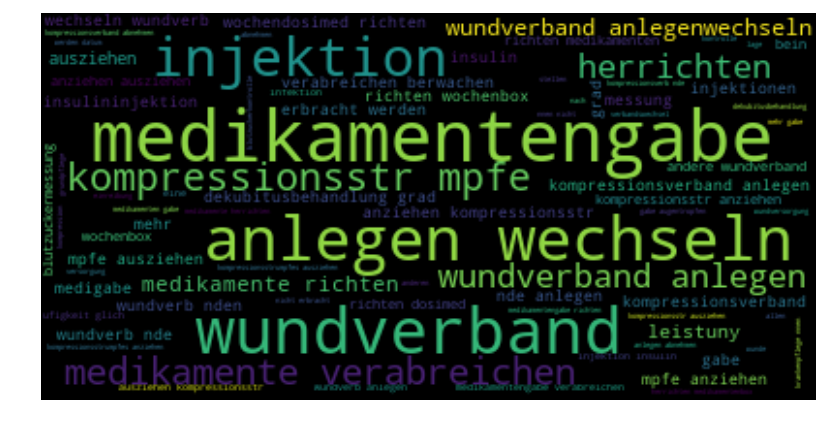

In [1133]:
text= df.text.apply(lambda x:','.join(x))
text= text.str.cat(sep=' ')

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig(fname="/Users/fabian/Desktop/IBM_Thesis/03_Python/exports/wordcloud.png", bbox_inches = 'tight')
plt.show()

## Spelling Corrector

In [688]:
# load dataset
x = []
val=0;non_val=0

with open(raw_dec06, 'r') as f:
    for line in f:
        # filter by minimum length
        if len(line)>=18:
            x.append(line) 
            val+=1
        else:
            #print(line)
            non_val+=1
    print("Valid docuemnts:",val,"Invalid documents:",non_val)

Valid docuemnts: 15143 Invalid documents: 357


In [689]:
inp=[]; clean=[]; tokenized=[]; corrected=[]; germanized=[];

for i in range(len(x[:5])):
        m = re.search(';', x[i])
        note = x[i][m.start()+1:]; inp.append(note)
        temp_clean = clean_str(note); clean.append(temp_clean)
        toks= nltk.word_tokenize(note); tokenized.append(toks)
        corrs= correct_word_in_sentence(temp_clean).split(); corrected.append(corrs)
        ger= german(text=corrs, vocab=hkp); germanized.append(ger)

df_spelling= pd.DataFrame({"Input": inp , "Tokenized": tokenized,
                          "Corrected":corrected, "German":germanized})
df_spelling

,Input,Tokenized,Corrected,German
0,LOIStUnY KOMPRESSOOSS IRUMDI HOHPRESSIOOSS IRÜMPH 11 AOZEHER SUSZIEHEN\n,"[LOIStUnY, KOMPRESSOOSS, IRUMDI, HOHPRESSIOOSS, IRÜMPH, 11, AOZEHER, SUSZIEHEN]","[leistung, kompressions, irumdi, hohpressiooss, im, max, aozeher, ausziehen]",leistung kompressions im max ausziehen
1,Leistung Medikamentengabe KompressionsverbÃ¤nde Anlegen Konprenionseerbande abnehmen RR- Kontrolle\n,"[Leistung, Medikamentengabe, KompressionsverbÃ¤nde, Anlegen, Konprenionseerbande, abnehmen, RR-, Kontrolle]","[medikamentengabe, kompressionsverb, anlegen, konprenionseerbande, abnehmen, kontrolle]",medikamentengabe anlegen abnehmen
2,LEISTUNG 83712 Nerkandswecsc 374\n,"[LEISTUNG, 83712, Nerkandswecsc, 374]",[nerkandswecsc],
3,L1 : i.m . Injektionen LO : Medikamente verabreichen/Ã¼berwachen\n,"[L1, :, i.m, ., Injektionen, LO, :, Medikamente, verabreichen/Ã¼berwachen]","[injektionen, medikamente, verabreichen, berwachen]",injektionen medikamente verabreichen
4,CO Angentropfnf-Salbe\n,"[CO, Angentropfnf-Salbe]","[angentropfnf, salbe]",salbe


## Sequence Length

In [1074]:
df= df_dataset1.copy()
#df.label= df.label.apply(lambda x: ','.join(x))
#df.text= df.text.apply(lambda x: ' '.join(x))

df['word_count'] = df['text'].str.len()
df['character_count'] = df['text'].apply(lambda x: ' '.join(x)).str.len()
df['label_count'] = df['label'].str.len()
df.head()

,text,label,word_count,character_count,label_count
0,"[loistuny, kompressooss, irumdi, hohpressiooss, ir, mph, aozeher, susziehen]","[298, 299]",8,67,2
1,"[medikamentengabe, kompressionsverb, anlegen, konprenionseerbande, abnehmen, kontrolle]","[233, 308, 387, 201]",6,80,4
2,[nerkandswecsc],[322],1,13,1
3,"[injektionen, medikamente, verabreichen, berwachen]","[325, 233]",4,46,2
4,"[angentropfnf, salbe]",[234],2,18,1


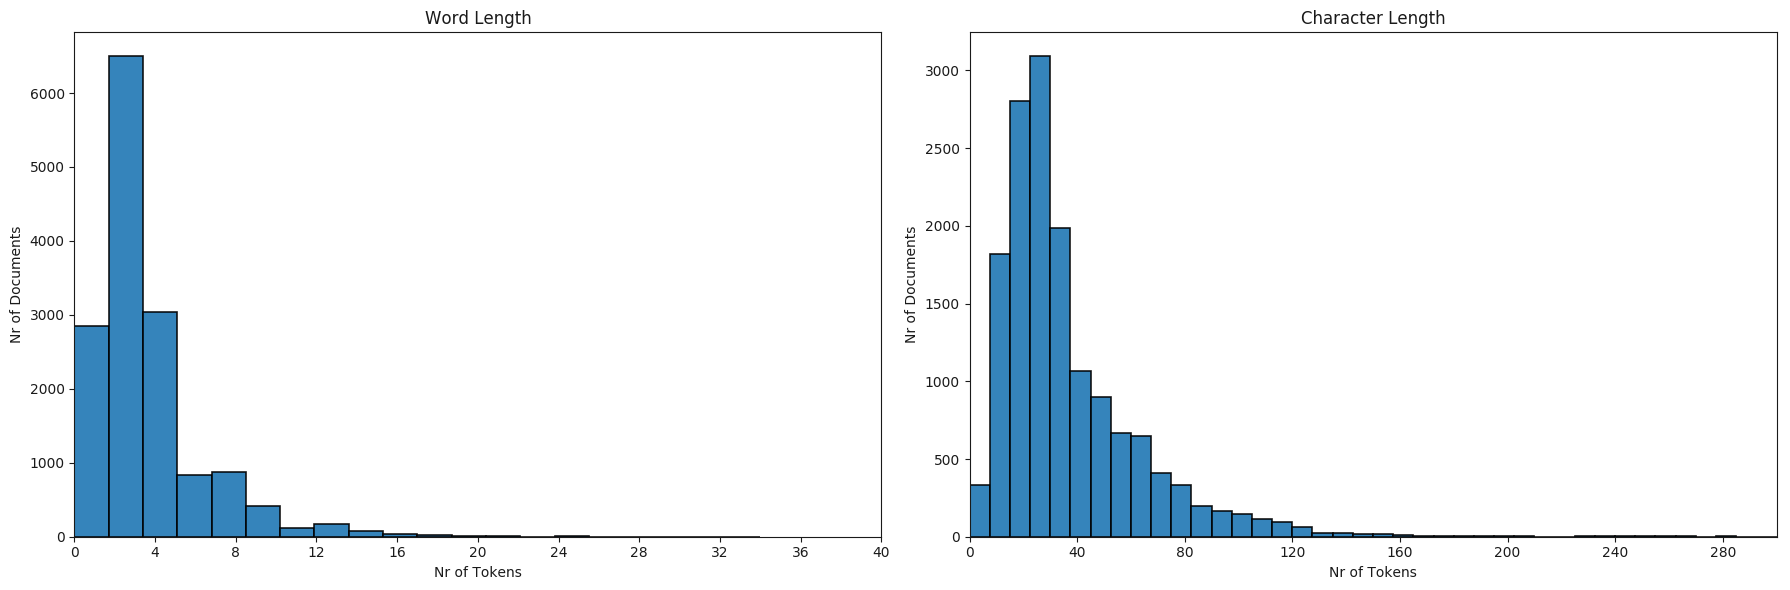

In [1089]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

axes[0].hist(df.word_count,20,alpha=0.9, edgecolor='black', linewidth=1.2)
axes[0].set_title('Word Length')
axes[0].set_xticks(ticks=np.arange(0,80,4), minor=False)
axes[0].set_xlim([0, 40])

axes[1].hist(df.character_count,40,alpha=0.9, edgecolor='black', linewidth=1.2)
axes[1].set_title('Character Length')
axes[1].set_xticks(ticks=np.arange(0,440,40), minor=False)
axes[1].set_xlim([0, 300])

for ax in axes.flat:
    ax.set(xlabel='Nr of Tokens', ylabel='Nr of Documents')
    
fig.tight_layout()
plt.show()

## Label Distribution

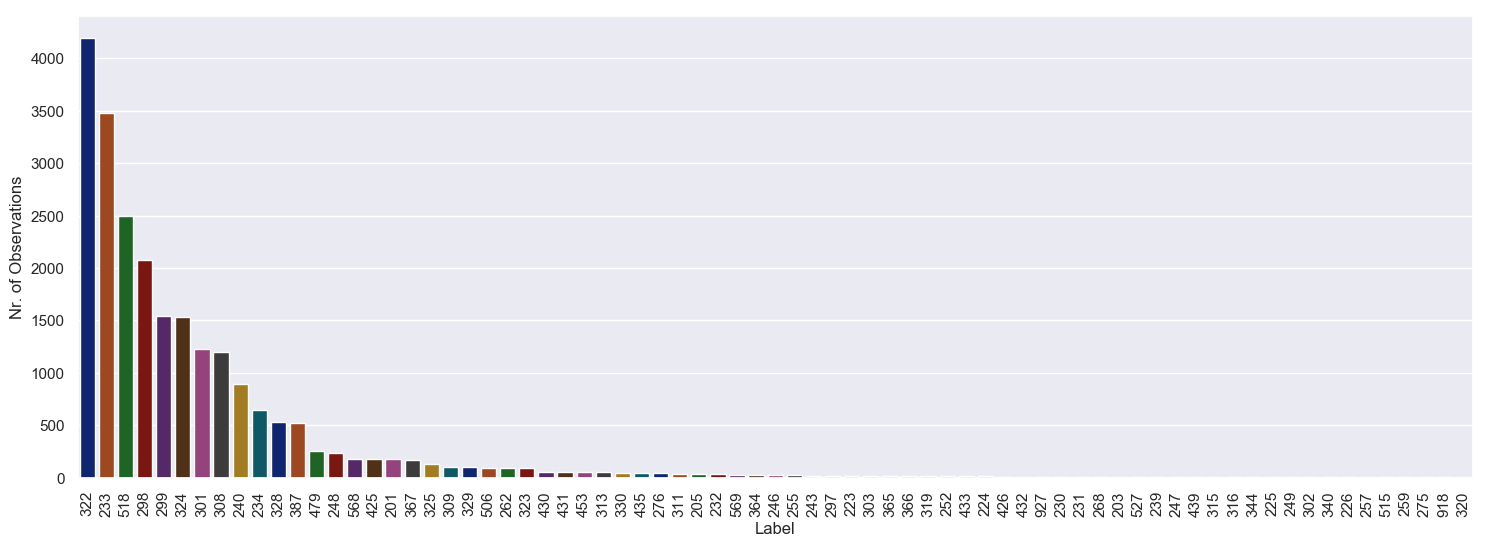

In [847]:
plt.rcParams.update(plt.rcParamsDefault)

sns.set(rc={'figure.figsize':(18,6)})
result = df_dataViz.groupby(["Label"])['Nr. of Observations'].aggregate(np.median).reset_index().sort_values('Nr. of Observations',ascending=False)
lab_des= sns.barplot(x='Label', y="Nr. of Observations", data=df_dataViz, order=result['Label'],palette=palette)


for item in lab_des.get_xticklabels():
    item.set_rotation(90)

plt.savefig(fname="/Users/fabian/Desktop/IBM_Thesis/03_Python/exports/labDis.jpg", bbox_inches = 'tight')
plt.show()

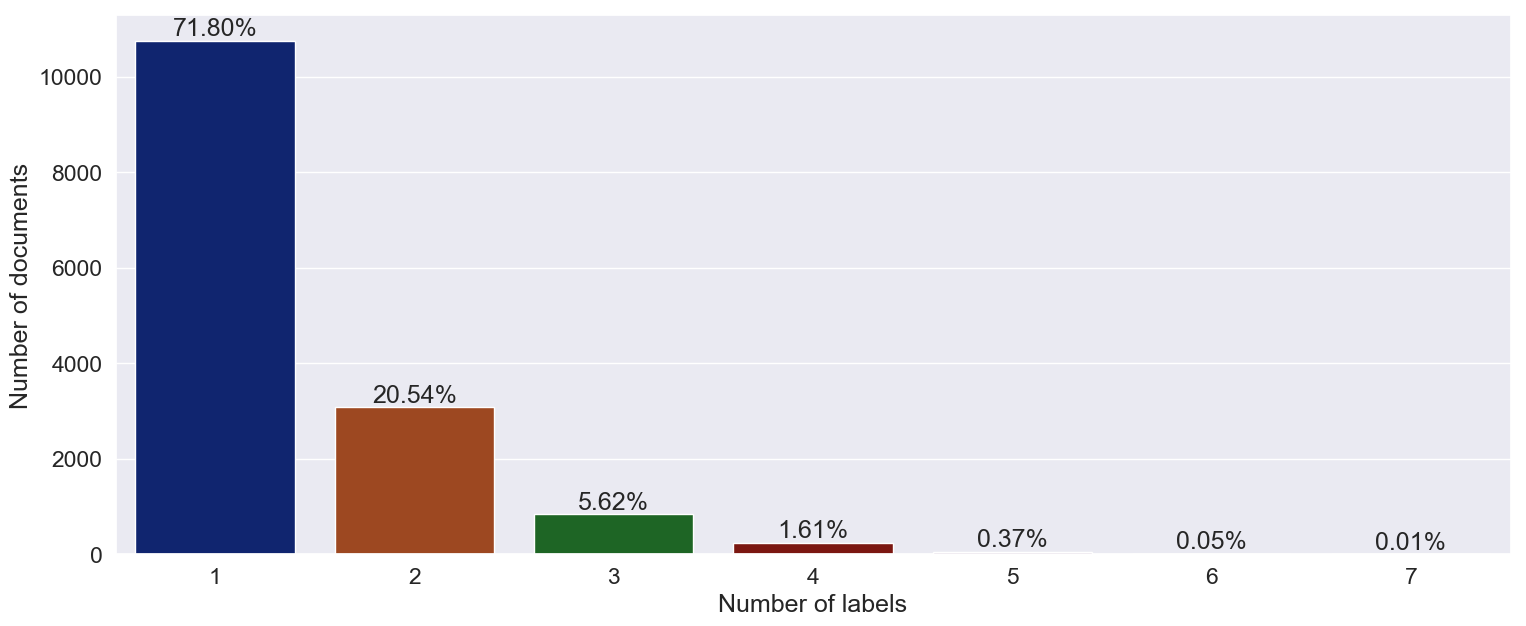

In [1229]:
pd.options.display.float_format = '{:.2f}%'.format

rowSums = data_raw.iloc[:,1:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[0:]

sns.set(font_scale = 1.5)
plt.figure(figsize=(18,7))

ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values, palette=palette)

plt.title("")
plt.ylabel('Number of documents', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)

#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values/multiLabel_counts.values.sum()
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, '{:.2%}'.format(label), ha='center', va='bottom')

plt.show()

In [721]:
df_counter = pd.DataFrame.from_dict(label_counter, orient='index').reset_index()
df_counter = df_counter.rename(columns={ df_counter.columns[1]:"count"}).rename(columns={ df_counter.columns[0]:"label"})
df_counter = df_counter.sort_values(by=['count'],ascending=False)
df_counter['cum_sum'] = df_counter['count'].cumsum()
df_counter['perc'] = 100*df_counter['count']/df_counter['count'].sum()
df_counter['cum_perc'] = 100*df_counter['cum_sum']/df_counter['count'].sum()

df_dataViz= pd.merge(df_counter, df_desc)

df_dataViz= df_dataViz.rename(columns={'label':'Label','count':'Nr. of Observations','cum_sum':'Cumulative Sum','perc':'Percentage',
                       'cum_perc':'Cumulative Percentage','description':'Description'})

#render dataframe as html
html = df_dataViz.to_html()

#write html to file
text_file = open("dataViz.html", "w")
text_file.write(html)
text_file.close()

df_dataViz

,Label,Nr. of Observations,Cumulative Sum,Percentage,Cumulative Percentage,Description
0,322,4200,4200,18.37%,18.37%,Anlegen und Wechseln von Wundverbänden
1,233,3475,7675,15.20%,33.57%,Arzneien verabreichen und überwachen
2,518,2495,10170,10.91%,44.48%,Richten von Medikamenten (Wochendosimed)
3,298,2077,12247,9.08%,53.57%,Anziehen von Kompressionsstrümpfen
4,299,1539,13786,6.73%,60.30%,Ausziehen von Kompressionsstrümpfen
5,324,1535,15321,6.71%,67.02%,"Injektion, s.c."
6,301,1231,16552,5.38%,72.40%,Insulininjektion
7,308,1194,17746,5.22%,77.62%,Kompressionsverbände
8,240,895,18641,3.91%,81.54%,Blutzucker messen
9,234,645,19286,2.82%,84.36%,Gabe von Salbe und Tropfen Augen


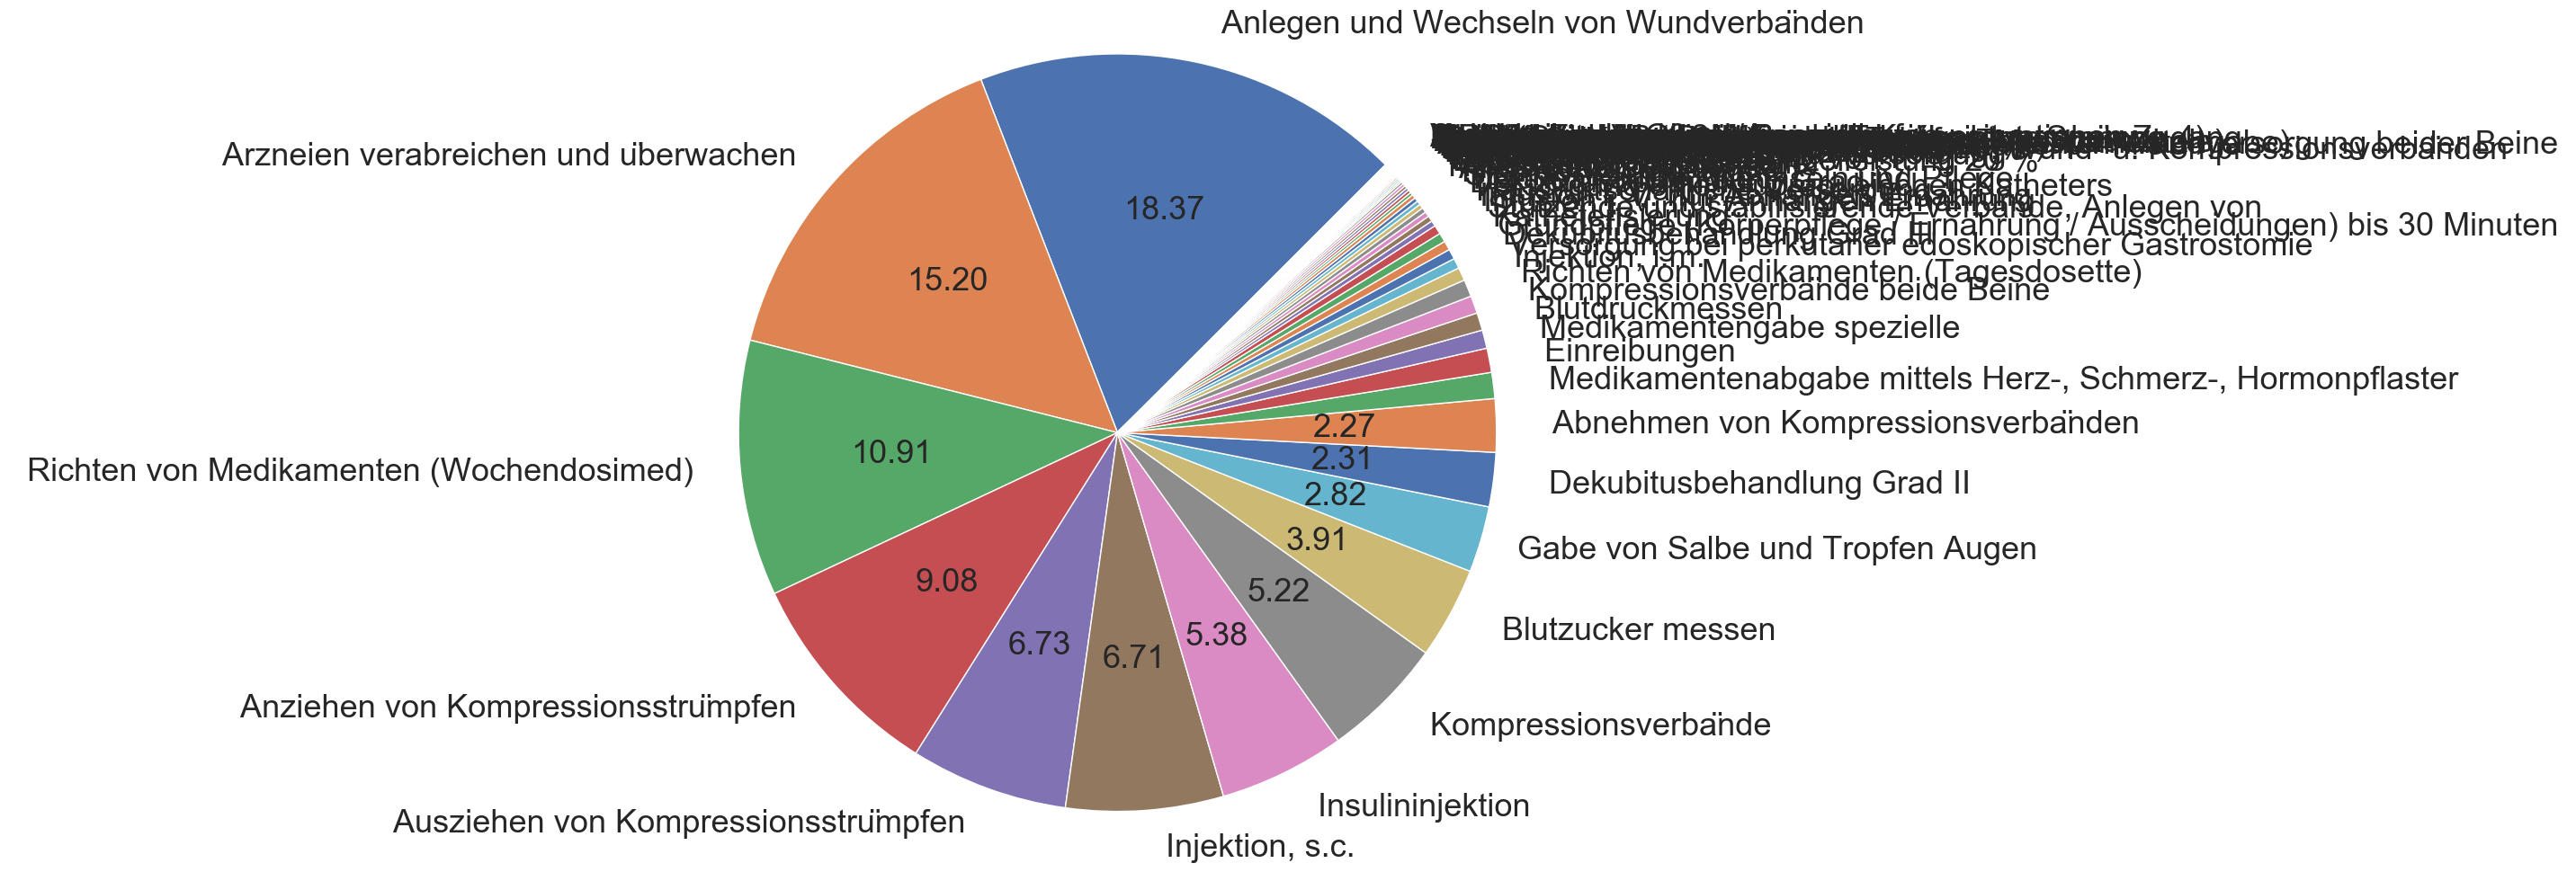

In [849]:
def my_autopct(pct):
    return ('%.2f' % pct) if pct > 2 else ''

plt.figure(figsize=(12,12))
plt.pie(x= df_dataViz['Nr. of Observations'], labels= df_dataViz.Description,autopct= my_autopct, startangle=45, textprops= {'fontsize': 26})
plt.axis('equal')
plt.show()

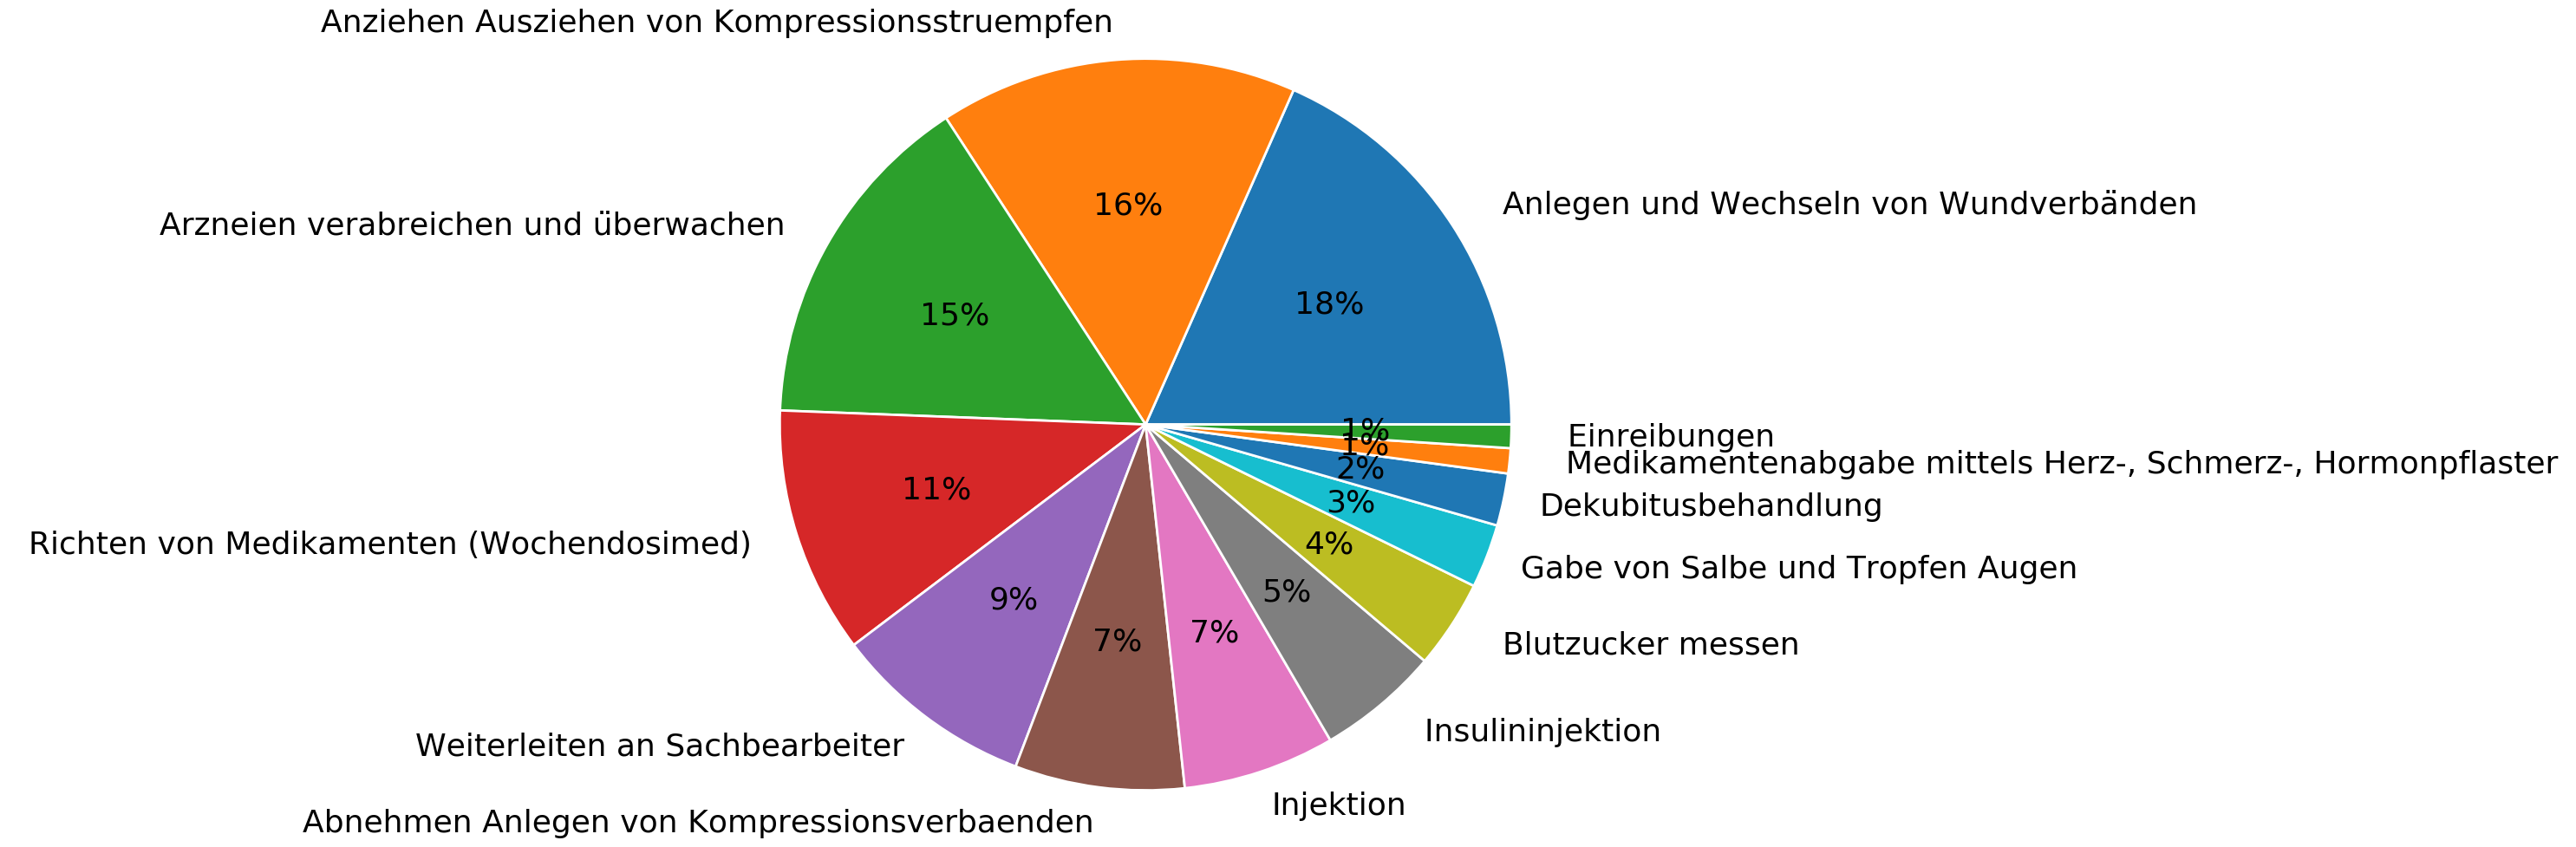

In [1094]:
# check label distribution 
label_list_stand = list(itertools.chain.from_iterable(lab_stand))
label_counter_stand= Counter(label_list_stand)


df_counter_standardized = pd.DataFrame.from_dict(label_counter_stand, orient='index').reset_index()
df_counter_standardized = df_counter_standardized.rename(columns={ df_counter_standardized.columns[1]:"count"}).rename(columns={ df_counter_standardized.columns[0]:"label"})
df_counter_standardized = df_counter_standardized.sort_values(by=['label'],ascending=True)
df_counter_standardized = df_counter_standardized.sort_values(by=['count'],ascending=False)
df_counter_standardized['cum_sum'] = df_counter_standardized['count'].cumsum()
df_counter_standardized['perc'] = 100*df_counter_standardized['count']/df_counter_standardized['count'].sum()
df_counter_standardized['cum_perc'] = 100*df_counter_standardized['cum_sum']/df_counter_standardized['count'].sum()

df_dataViz_standardized= pd.merge(df_counter_standardized, df_desc)



def my_autopct(pct):
    return ('%.1f' % pct) if pct > 2 else ''

theme = plt.get_cmap('copper')
#ax1.set_prop_cycle("color", [theme(1. * i / len(sizes))for i in range(len(sizes))])

plt.figure(figsize=(12,12))
plt.pie(x= df_dataViz_standardized['count'], labels= df_dataViz_standardized['description'],
       #autopct= my_autopct, 
        startangle=0, 
        wedgeprops = { 'linewidth' : 2 , 'edgecolor' : 'white'},
        autopct='%1.0f%%',
        #shadow=True,
        textprops= {'fontsize': 26})

plt.rcParams['text.color'] = 'black'
plt.rcParams['lines.linewidth'] = 5

plt.axis('equal')
plt.savefig(fname="/Users/fabian/Desktop/IBM_Thesis/03_Python/exports/pie.png", bbox_inches = 'tight')
plt.show()

In [1104]:
text = df.text.values
text

array([list(['loistuny', 'kompressooss', 'irumdi', 'hohpressiooss', 'ir', 'mph', 'aozeher', 'susziehen']),
       list(['medikamentengabe', 'kompressionsverb', 'anlegen', 'konprenionseerbande', 'abnehmen', 'kontrolle']),
       list(['nerkandswecsc']), ...,
       list(['wochendorinter', 'eines', 'allen', 'wundverband', 'st', 'ma', 'versorgen']),
       list(['reaktionentsbox', 'stelle', 'augen', 'injektion', 'allen', 'kompressionstruise', 'ansiche', 'kimmersinsst', 'runge', 'ausziehen']),
       list(['herrichten', 'einer', 'dekubitusbehandlung', 'injektion', 'medigabe', 'blutzuckerkonts'])],
      dtype=object)

## Label Correlation

In [1204]:
list(df_dataViz.Label[:12])

['322',
 '233',
 '518',
 '298',
 '299',
 '324',
 '301',
 '308',
 '240',
 '234',
 '328',
 '387']

In [1213]:
df_dataViz_standardized.head()

,label,count,cum_sum,perc,cum_perc,description
0,322,4200,4200,18.37%,18.37%,Anlegen und Wechseln von Wundverbänden
1,101,3616,7816,15.82%,34.19%,Anziehen Ausziehen von Kompressionsstruempfen
2,233,3475,11291,15.20%,49.39%,Arzneien verabreichen und überwachen
3,518,2495,13786,10.91%,60.30%,Richten von Medikamenten (Wochendosimed)
4,111,2039,15825,8.92%,69.22%,Weiterleiten an Sachbearbeiter


In [1214]:
cols_target= list(df_dataViz_standardized.label[:12])
data = df_dataset2_ohe[cols_target]

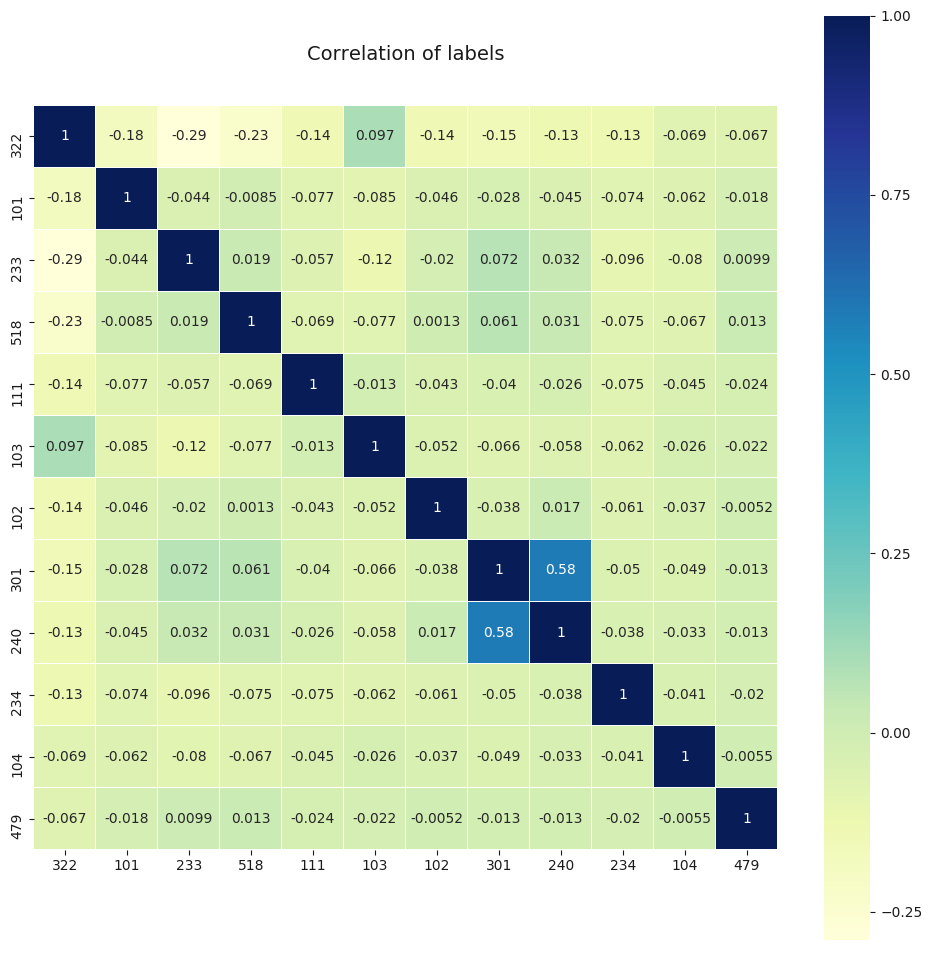

In [1224]:
colormap = plt.cm.plasma
plt.figure(figsize=(12,12))
plt.title('Correlation of labels',y=1.05,size=14)

sns.heatmap(data.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap="YlGnBu",
           linecolor='white',annot=True)
plt.show()

## Chars2Vec 

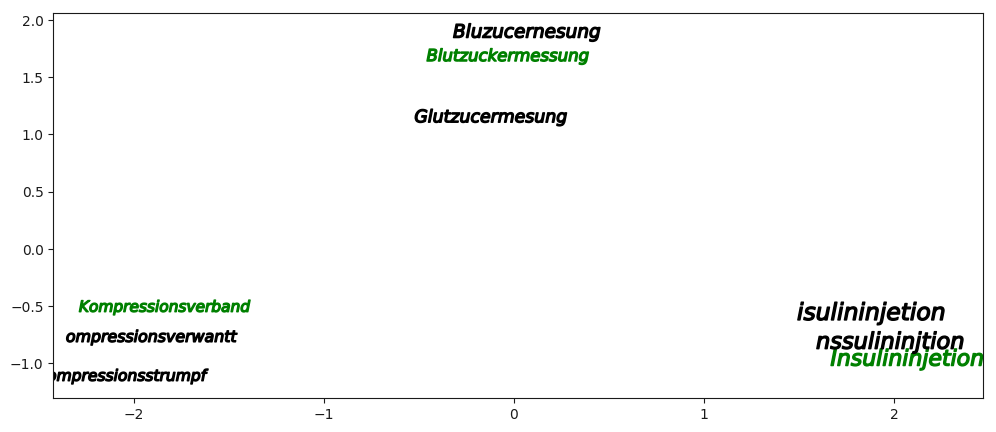

In [1227]:
import sklearn

c2v_model = chars2vec.load_model('eng_50')

words = ['Blutzuckermessung', 'Glutzucermesung','Bluzucernesung',
         'Kompressionsverband','Kompressionsstrumpf','ompressionsverwantt',
         'Insulininjetion','nssulininjtion','isulininjetion',
         ]

# Create word embeddings
word_embeddings = c2v_model.vectorize_words(words)

# Project embeddings on plane using the PCA
projection_2d = sklearn.decomposition.PCA(n_components=2).fit_transform(word_embeddings)

# Draw words on plane
f = plt.figure(figsize=(12, 5))

for j in range(len(projection_2d)):
    plt.scatter(projection_2d[j, 0], projection_2d[j, 1],
    marker=('$' + words[j] + '$'),
    s=800 * len(words[j]), label=j,
    facecolors='green' if words[j] in ['Blutzuckermessung','Kompressionsverband','Insulininjetion'] else 'black')
    
plt.savefig(fname="/Users/fabian/Desktop/IBM_Thesis/03_Python/exports/chars2vec.jpg", bbox_inches = 'tight')
plt.show()

## Evaluation

In [1272]:
leam_pred_path= 'leam_pred_pickle.npy '

In [1273]:
#leam_pred= pickle.load(open((leam_pred_path % path), "rb"))
leam_pred= np.load(leam_pred_path)
leam_pred= np.squeeze(np.array(leam_pred))
leam_pred.shape

(2995, 73)

In [1268]:
from sklearn.metrics import confusion_matrix
leam_conf=  confusion_matrix(
            leam_pred.argmax(axis=1), 
            np.around(leam_pred,0).argmax(axis=1)
            )

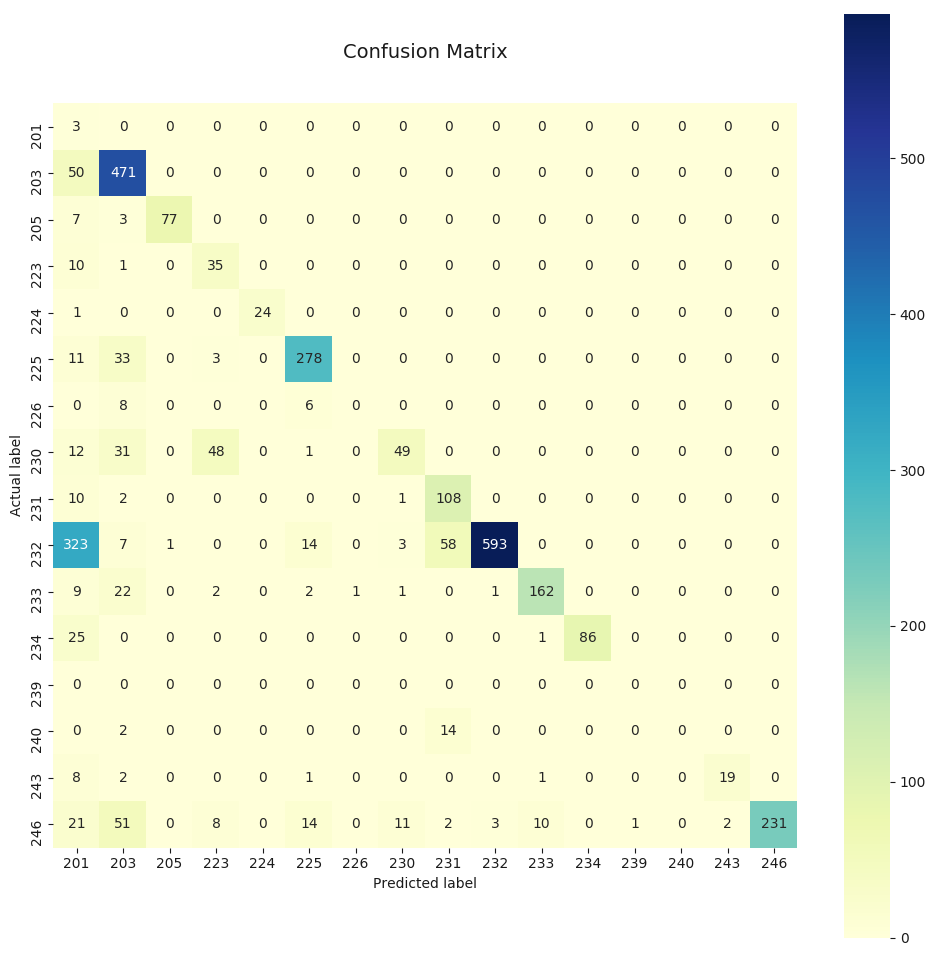

In [1271]:
plt.rcParams.update(plt.rcParamsDefault)

colormap = plt.cm.plasma
plt.figure(figsize=(12,12))
plt.title('Confusion Matrix',y=1.05,size=14)



ax= sns.heatmap(leam_conf,
            #linewidths=0.1,vmax=1.0,
            square=True,cmap="YlGnBu",
            linecolor='white',annot=True,fmt='g')
ax.set(xlabel='Predicted label', ylabel='Actual label')
ax.set_xticklabels([''] + mlb.classes_)
ax.set_yticklabels([''] + mlb.classes_)
plt.savefig(fname="/Users/fabian/Desktop/IBM_Thesis/03_Python/exports/confusion_matrix.png", bbox_inches = 'tight')
plt.show()

## Label Embedding

In [1296]:
df= df_multiclass.copy()
print(df.shape)
df.text= df.text.apply(lambda x:' '.join(x))
df.label= df.label.apply(lambda x:' '.join(x))
df= df[df.label != '111']
df= df[df.label != '102']

filter = df["text"] != ""
df = df[filter]
print(df.shape)
df.head(3)

(9687, 2)
(8011, 2)


,text,label
2,nerkandswecsc,322
4,angentropfnf salbe,234
6,leistuny teditamentengabe,233


In [1297]:
mlb.fit_transform([df.label.values])
print(len(mlb.classes_))
mlb.classes_

11


array(['101', '103', '104', '233', '234', '240', '248', '301', '322',
       '479', '518'], dtype=object)

### Cosine Similarity Matrix

In [1299]:
# firstly we compute the averaged document embeddings per classb

doc_matrix = np.empty((0, 300))

for label in mlb.classes_:
    values= df.text[df.label==label].values
    name_list = [ k.lower().split(' ') for k in values]
    id_list = [[ wordtoix[i] for i in g if len(i)>2] for g in name_list]
    value_list = [ [ hkp_embeddings[i] for i in l]    for l in id_list]
    value_mean = [ np.mean(l,0)  for l in value_list]
    arr= np.asarray(value_mean)
    arr_avg= np.average(arr,axis=0)
    doc_matrix = np.append(doc_matrix, [arr_avg], axis=0)
print(doc_matrix.shape)

(11, 300)


In [1304]:
descriptions_clean = ['Anziehen Ausziehen Kompressionsstruempfen',
                     #'Injektion',
                     'Abnehmen Anlegen Kompressionsverbaenden',
                     'Dekubitusbehandlung',
                     #'Weiterleiten Sachbearbeiter',
                     'Arzneien verabreichen ueberwachen',
                     'Gabe Salbe Tropfen Augen',
                     'Blutzuckerkontrolle messen',
                     'Einreibungen',
                     'Insulininjektion',
                     'Anlegen Wechseln Wundverbaenden',
                     'Medikamentenabgabe Herz Schmerz Hormonpflaster',
                     'Richten Medikamenten Wochendosimed'
                    ]

In [1305]:
# compute the averaged embeddings per per label description

name_list = [ k.lower().split(' ') for k in descriptions_clean]
#id_list = [[ wordtoix[i] for i in g if len(i)>2] for g in descriptions]
id_list = [ [ wordtoix[i] for i in l if len(i)>2] for l in name_list]
value_list = [ [ hkp_embeddings[i] for i in l]    for l in id_list]
value_mean = [ np.mean(l,0)  for l in value_list]
desc_matrix= np.asarray(value_mean)
desc_matrix.shape

(11, 300)

In [1306]:
import scipy.spatial as sp
cos_matrix= 1- sp.distance.cdist(doc_matrix, desc_matrix, 'cosine')
cos_matrix.shape

(11, 11)

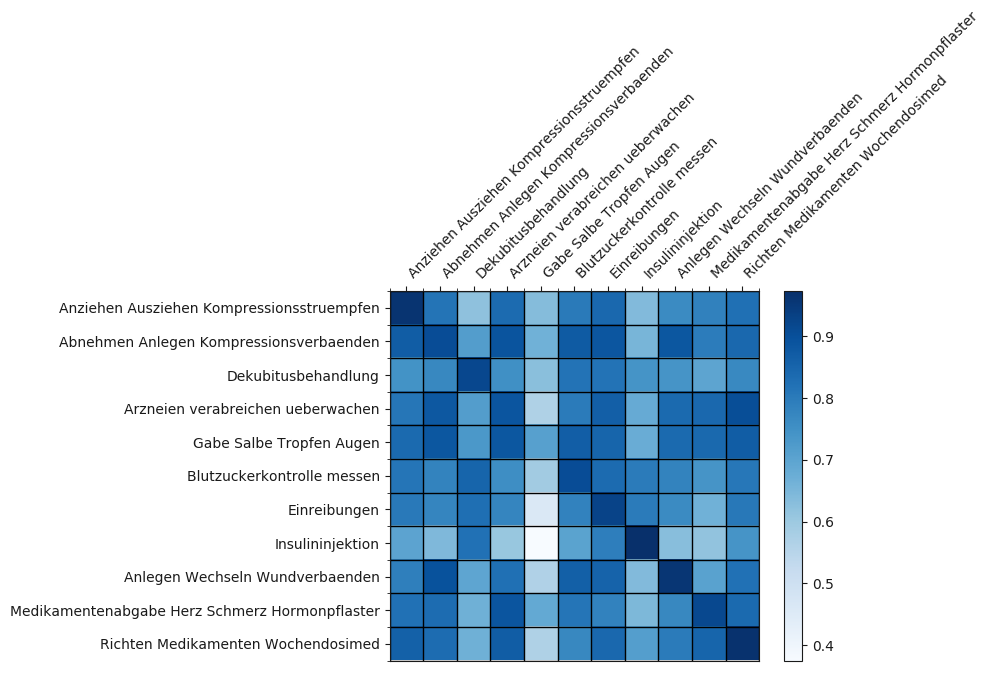

In [1309]:
plt.imshow(cos_matrix, cmap='Blues',)
plt.colorbar(); plt.grid(False)
ax = plt.gca(); ax.xaxis.tick_top()
ax.set_xticks(np.arange(0, 11, 1)); ax.set_yticks(np.arange(0, 11, 1));
ax.set_xticklabels(descriptions_clean, rotation = 45, ha="left",);
ax.set_yticklabels(descriptions_clean);
ax.set_xticks(np.arange(-.5, 11, 1), minor=True); ax.set_yticks(np.arange(-.5, 11, 1), minor=True);
ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
plt.savefig('/Users/fabian/Desktop/IBM_Thesis/03_Python/exports/Covariance_matrix.pdf', bbox_inches='tight')
plt.show()

### t-SNE plot

In [1317]:
desc_id_list = [[ wordtoix[i] for i in g if len(i)>2] for g in descriptions_clean[:2]]
desc_value_list = [ [ hkp_embeddings[i] for i in l]    for l in desc_id_list]
desc_value_mean = [ np.mean(l,0)  for l in desc_value_list]
desc_arr= np.asarray(desc_value_mean)
desc_arr.shape

(2,)

In [1318]:
# compute the averaged embeddings per per label description

name_list = [ k.lower().split(' ') for k in descriptions_clean]
#id_list = [[ wordtoix[i] for i in g if len(i)>2] for g in descriptions]
id_list = [ [ wordtoix[i] for i in l if len(i)>2] for l in name_list]
value_list = [ [ hkp_embeddings[i] for i in l]    for l in id_list]
value_mean = [ np.mean(l,0)  for l in value_list]
desc_arr= np.asarray(value_mean)
desc_arr.shape

(11, 300)

In [1352]:
#test= df.text.apply(lambda x:' '.join(x))

name_list = [ k.lower().split(' ') for k in df.text]
id_list = [[ wordtoix[i] for i in g if len(i)>2] for g in name_list]
#id_list = [ [ wordtoix[i] for i in l if len(i)>2] for l in name_list]
value_list = [ [ hkp_embeddings[i] for i in l]    for l in id_list]
value_mean = [ np.mean(l,0)  for l in value_list]
doc_arr= np.asarray(value_mean)
doc_arr.shape

(8011, 300)

In [1353]:
X = np.concatenate([doc_arr,desc_arr])
y = np.array(df.label)
y = np.append(y,mlb.classes_)

print(X.shape, y.shape)

(8022, 300) (8022,)


In [1354]:
colors =  'orangered','blue','magenta','pink','gold','grey', 'darkgreen', 'black', 'c', 'm', 'lime', 'k', 'w', 'orange'
#colors = 'black','maroon','darkorange','peru','gold','olive','lawngreen','dodgeblue','darkviolet','deeppink','cyan','blue','y'

In [1355]:
mlb.classes_

array(['101', '103', '104', '233', '234', '240', '248', '301', '322',
       '479', '518'], dtype=object)

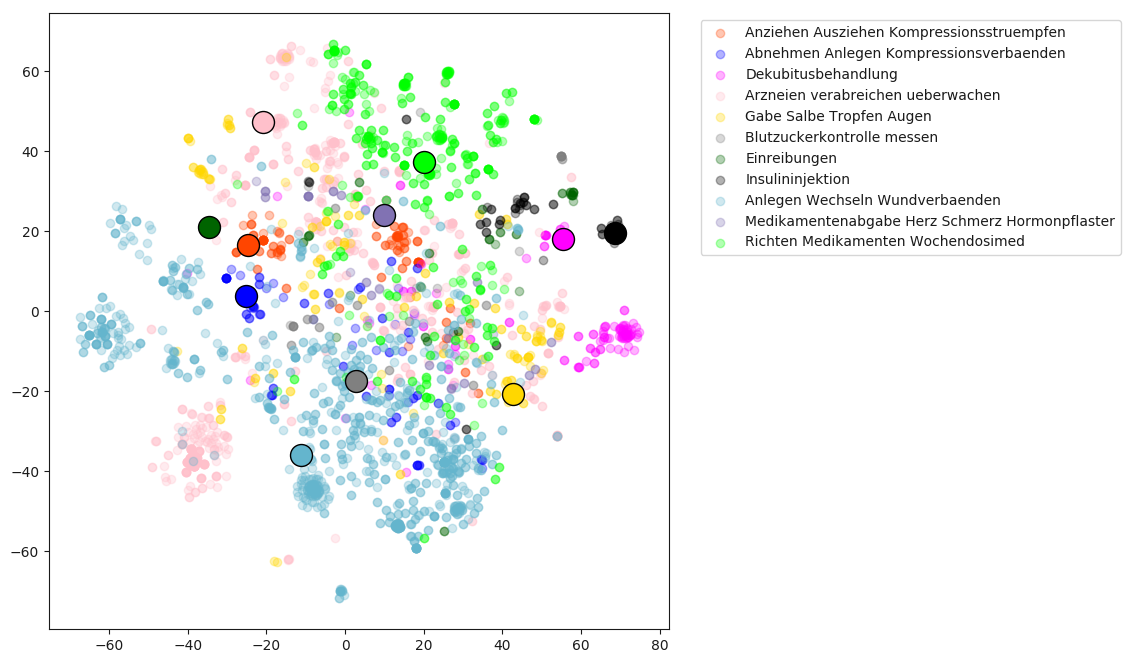

In [1360]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, 
            perplexity=30 ,early_exaggeration=12, learning_rate= 100.0
           )

#X_2d = tsne.fit_transform(X)
#X_2d= np.where(X_2d>30,0,X_2d); X_2d= np.where(X_2d<-30,0,X_2d)

docs= X_2d[:3000]; y_docs= y[:3000]
lab= X_2d[-11:]; y_lab= y[-11:]

classes= mlb.classes_
#classes= ['103', '233', '234', '240', '248', '301', '322','479', '518']
target_ids = range(len(classes));# print(target_ids); print(classes)

plt.figure(figsize=(8, 8))
for index, i, c, label in zip(range(11), target_ids, colors, classes):
    plt.scatter(docs[y_docs == classes[i], 0], docs[y_docs ==classes[i], 1], c=c, label=label,alpha=0.3, marker="o")
    
for index, i, c in zip(range(11), target_ids, colors):
    plt.scatter(lab[y_lab == classes[i], 0], lab[y_lab ==classes[i], 1], c=c, s=250,edgecolors='black', marker="o")

    
#plt.scatter(X_2d[1000:1011,0],X_2d[1000:1011,1],s=100,c='orange',edgecolors='black')

plt.legend(
    descriptions_clean, 
    bbox_to_anchor=(1.04,1), loc="upper left")
plt.savefig('/Users/fabian/Desktop/IBM_Thesis/03_Python/exports/tSNE.pdf', bbox_inches='tight')
plt.show()

### Highlight medical text with Attention score ß

In [1364]:
ß = np.load('leam_attention_scores.npz',allow_pickle=True)

In [1373]:
path= '/Users/fabian/Desktop/IBM_Thesis/03_Python/labelEmbedding/LEAM/data/'
output_pickle = '%s/aok/noisy_13_dec06.p'
x = pickle.load(open((output_pickle % path), "rb"))

train, train_text, train_lab = x[0],x[1], x[2]
val, val_text, val_lab = x[3],x[4], x[5]
test, test_text, test_lab = x[6],x[7], x[8]
wordtoix, ixtoword, description_clean = x[9], x[10], x[11]

In [1374]:
t= np.array(train[:100])
l= train_lab[:100]
print(t.shape, l.shape)

(100,) (100, 13)


In [1379]:
test_sents = ß['test_sents'];  
test_sents= t
test_labels= l
Att_h = ß['Att_h'];  print(Att_h.shape)
Att_v = ß['Att_v'];  print(Att_v.shape)

(100, 305, 10)
(100, 305, 1)


In [1376]:
test_sents_words = []
for j in test_sents:
    sent = [ixtoword[i] for i in j]
    test_sents_words.append(sent)

In [1377]:
for i, words, alphas_values in zip(range(20), test_sents_words, Att_v):
    with open("visualization_{}.html".format(i), "w") as html_file:
        for word, alpha in zip(words, alphas_values / alphas_values.max()):
            if word == ":START:":
                continue
            elif word == ":PAD:":
                break
            html_file.write('<font style="background: rgba(0, 0, 255, %f)">%s</font>\n' % (alpha*1.3, word))

In [1378]:
with open("attention_highlights.html", "w") as html_file:
    for word, alpha in zip(words, alphas_values / alphas_values.max()):
        if word == ":START:":
            continue
        elif word == ":PAD:":
            break
        html_file.write('<font style="background: rgba(255, 255, 255, %f)">%s</font>\n' % (alpha, word))

In [1383]:

    for filename in os.listdir('/Users/fabian/Desktop/IBM_Thesis/03_Python/attention highlights/'):
        if filename.endswith('.html'):
            #print(filename)
            display(HTML(filename))